# Predicting the energy usage of appliances

## Summary

This project analyzes 3 predictive models for the energy use of appliances. 
* **gbm model** = Gradient boosting machines
* **svm model** = Support vector machine w/radial kernel
* **liner model** = Multilinear regression

To analyze the features importance a **random forest classifier model** were used

### Facts
* Data used include measurements of:
    + temperature and humidity sensors from a wireless network as IoT
    + whether from a nearby airport station
    + recorded energy use of lighting fixtures
* Measures come from one apartment
* Some data filtering to remove non-predictive parameters and feature ranking was done
* The data set is at 10 min for about 4.5 months. That is, the wireless data was averaged for every 10 minutes periods and each measure was record every minute
* The house temperature and humidity conditions were monitored with a wireless sensor network
* Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru) and merged together with the experimental data sets using the datetime column
* Data was downloaded from "https://s3.amazonaws.com"


## Steps

* Import the dataset
* Clean and transform data as required
* Exploratory data analysis
* Feature creation
* Model Creation
* Model Validation
* Generate Prediction

## Tools

* Python Pandas
* Python Matplotlib
* seaborn
* Sci-Kit Learn

### Data set:
* **Index;**      Datetime for each 10 minutes period 
* **Appliances;** Energy use in Wh 
* **lights;**     Energy use of light fixtures in the house in Wh 
----
#### Temperature of each room:
* **T1;**         Temperature in kitchen area, in Celsius 
* **RH_1;**       Humidity in kitchen area, in % 
* **T2;**         Temperature in living room area, in Celsius 
* **RH_2;**       Humidity in living room area, in % 
* **T3;**         Temperature in laundry room area 
* **RH_3;**       Humidity in laundry room area, in % 
* **T4;**         Temperature in office room, in Celsius 
* **RH_4;**       Humidity in office room, in % 
* **T5;**         Temperature in bathroom, in Celsius 
* **RH_5;**       Humidity in bathroom, in % 
* **T6;**         Temperature outside the building (north side), in Celsius 
* **RH_6;**       Humidity outside the building (north side), in % 
* **T7;**         Temperature in ironing room , in Celsius 
* **RH_7;**       Humidity in ironing room, in % 
* **T8;**         Temperature in teenager room 2, in Celsius 
* **RH_8;**       Humidity in teenager room 2, in % 
* **T9;**         Temperature in parents room, in Celsius 
* **RH_9;**       Humidity in parents room, in % 
----
#### Outside environment conditions:
* **To;**         Temperature outside (from Chievres weather station), in Celsius 
* **Pressure;**   (from Chievres weather station), in mm Hg 
* **RH_out;**     Humidity outside (from Chievres weather station), in % 
* **Wind speed;** (from Chievres weather station), in m/s 
* **Visibility;** (from Chievres weather station), in km 
* **Tdewpoint;**  (from Chievres weather station), Â°C 
----
#### Random variables for for testing the regression models:
* **rv1;** Random variable 1; nondimensional 
* **rv2;** Random variable 2; nondimensional 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from tqdm import tqdm

from subprocess import check_output
source="https://s3.amazonaws.com/hackerday.datascience/92/"

### Import the dataset

In [2]:
df_train = pd.read_csv(source+'training.csv')
df_train.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM,WeekStatus,Day_of_week
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,61200,Weekday,Monday
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,61800,Weekday,Monday
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,62400,Weekday,Monday
3,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,63600,Weekday,Monday
4,2016-01-11 17:50:00,50,40,19.89,46.026667,19.2,44.500000,19.79,44.933333,18.890000,...,734.0,92.0,5.333333,43.833333,4.8,44.919484,44.919484,64200,Weekday,Monday


In [3]:
df_train.shape

(14803, 32)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14803 entries, 0 to 14802
Data columns (total 32 columns):
date           14803 non-null object
Appliances     14803 non-null int64
lights         14803 non-null int64
T1             14803 non-null float64
RH_1           14803 non-null float64
T2             14803 non-null float64
RH_2           14803 non-null float64
T3             14803 non-null float64
RH_3           14803 non-null float64
T4             14803 non-null float64
RH_4           14803 non-null float64
T5             14803 non-null float64
RH_5           14803 non-null float64
T6             14803 non-null float64
RH_6           14803 non-null float64
T7             14803 non-null float64
RH_7           14803 non-null float64
T8             14803 non-null float64
RH_8           14803 non-null float64
T9             14803 non-null float64
RH_9           14803 non-null float64
T_out          14803 non-null float64
Press_mm_hg    14803 non-null float64
RH_out         14803 n

In [5]:
df_test = pd.read_csv(source+'testing.csv')
df_test.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM,WeekStatus,Day_of_week
0,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.79,45.000000,18.89,...,733.800000,92.000000,6.000000,51.5,5.000000,45.410389,45.410389,63000,Weekday,Monday
1,2016-01-11 18:00:00,60,50,19.890000,45.766667,19.200000,44.500000,19.79,44.900000,18.89,...,734.100000,92.000000,5.000000,40.0,4.700000,47.233763,47.233763,64800,Weekday,Monday
2,2016-01-11 18:40:00,230,70,19.926667,45.863333,19.356667,44.400000,19.79,44.900000,18.89,...,734.366667,91.333333,5.666667,40.0,4.633333,10.298729,10.298729,67200,Weekday,Monday
3,2016-01-11 18:50:00,580,60,20.066667,46.396667,19.426667,44.400000,19.79,44.826667,19.00,...,734.433333,91.166667,5.833333,40.0,4.616667,8.827838,8.827838,67800,Weekday,Monday
4,2016-01-11 19:30:00,100,10,20.566667,53.893333,20.033333,46.756667,20.10,48.466667,19.00,...,734.850000,89.500000,6.000000,40.0,4.350000,24.884962,24.884962,70200,Weekday,Monday


In [6]:
df_test.shape

(4932, 32)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14803 entries, 0 to 14802
Data columns (total 32 columns):
date           14803 non-null object
Appliances     14803 non-null int64
lights         14803 non-null int64
T1             14803 non-null float64
RH_1           14803 non-null float64
T2             14803 non-null float64
RH_2           14803 non-null float64
T3             14803 non-null float64
RH_3           14803 non-null float64
T4             14803 non-null float64
RH_4           14803 non-null float64
T5             14803 non-null float64
RH_5           14803 non-null float64
T6             14803 non-null float64
RH_6           14803 non-null float64
T7             14803 non-null float64
RH_7           14803 non-null float64
T8             14803 non-null float64
RH_8           14803 non-null float64
T9             14803 non-null float64
RH_9           14803 non-null float64
T_out          14803 non-null float64
Press_mm_hg    14803 non-null float64
RH_out         14803 n

In [8]:
df = df_train.append(df_test)

df.shape

(19735, 32)

In [9]:
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM,WeekStatus,Day_of_week
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,61200,Weekday,Monday
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,61800,Weekday,Monday
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,62400,Weekday,Monday
3,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,63600,Weekday,Monday
4,2016-01-11 17:50:00,50,40,19.89,46.026667,19.2,44.500000,19.79,44.933333,18.890000,...,734.0,92.0,5.333333,43.833333,4.8,44.919484,44.919484,64200,Weekday,Monday


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19735 entries, 0 to 4931
Data columns (total 32 columns):
date           19735 non-null object
Appliances     19735 non-null int64
lights         19735 non-null int64
T1             19735 non-null float64
RH_1           19735 non-null float64
T2             19735 non-null float64
RH_2           19735 non-null float64
T3             19735 non-null float64
RH_3           19735 non-null float64
T4             19735 non-null float64
RH_4           19735 non-null float64
T5             19735 non-null float64
RH_5           19735 non-null float64
T6             19735 non-null float64
RH_6           19735 non-null float64
T7             19735 non-null float64
RH_7           19735 non-null float64
T8             19735 non-null float64
RH_8           19735 non-null float64
T9             19735 non-null float64
RH_9           19735 non-null float64
T_out          19735 non-null float64
Press_mm_hg    19735 non-null float64
RH_out         19735 no

## Clean and transform data as required

* Calculate seconds in a day
* WeekStatus
* Day of week

In [11]:
from datetime import datetime

df.dtypes

date            object
Appliances       int64
lights           int64
T1             float64
RH_1           float64
T2             float64
RH_2           float64
T3             float64
RH_3           float64
T4             float64
RH_4           float64
T5             float64
RH_5           float64
T6             float64
RH_6           float64
T7             float64
RH_7           float64
T8             float64
RH_8           float64
T9             float64
RH_9           float64
T_out          float64
Press_mm_hg    float64
RH_out         float64
Windspeed      float64
Visibility     float64
Tdewpoint      float64
rv1            float64
rv2            float64
NSM              int64
WeekStatus      object
Day_of_week     object
dtype: object

In [12]:
pd.to_datetime(df['date']).dt.dayofweek

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
       ..
4902    3
4903    3
4904    3
4905    3
4906    3
4907    3
4908    3
4909    3
4910    3
4911    4
4912    4
4913    4
4914    4
4915    4
4916    4
4917    4
4918    4
4919    4
4920    4
4921    4
4922    4
4923    4
4924    4
4925    4
4926    4
4927    4
4928    4
4929    4
4930    4
4931    4
Name: date, Length: 19735, dtype: int64

In [13]:

(pd.to_datetime(df['date']).dt.dayofweek// 5 == 1).astype(float)

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
6       0.0
7       0.0
8       0.0
9       0.0
10      0.0
11      0.0
12      0.0
13      0.0
14      0.0
15      0.0
16      0.0
17      0.0
18      0.0
19      0.0
20      0.0
21      0.0
22      0.0
23      0.0
24      0.0
25      0.0
26      0.0
27      0.0
28      0.0
29      0.0
       ... 
4902    0.0
4903    0.0
4904    0.0
4905    0.0
4906    0.0
4907    0.0
4908    0.0
4909    0.0
4910    0.0
4911    0.0
4912    0.0
4913    0.0
4914    0.0
4915    0.0
4916    0.0
4917    0.0
4918    0.0
4919    0.0
4920    0.0
4921    0.0
4922    0.0
4923    0.0
4924    0.0
4925    0.0
4926    0.0
4927    0.0
4928    0.0
4929    0.0
4930    0.0
4931    0.0
Name: date, Length: 19735, dtype: float64

In [14]:
segundos=(pd.to_datetime(df['date']).dt.hour*3600)+(pd.to_datetime(df['date']).dt.minute*60)+(pd.to_datetime(df['date']).dt.second)
segundos

0       61200
1       61800
2       62400
3       63600
4       64200
5       65400
6       66000
7       66600
8       68400
9       69000
10      69600
11      70800
12      72000
13      72600
14      73200
15      75000
16      75600
17      76200
18      76800
19      78000
20      78600
21      79200
22      79800
23      80400
24      81000
25      81600
26      82800
27      83400
28      84000
29      84600
        ...  
4902    61800
4903    69000
4904    77400
4905    78600
4906    79200
4907    81000
4908    81600
4909    82800
4910    84000
4911      600
4912     3600
4913     4200
4914     8400
4915     9000
4916     9600
4917    15600
4918    18000
4919    20400
4920    21600
4921    24600
4922    30000
4923    31800
4924    33600
4925    36600
4926    39600
4927    49800
4928    52200
4929    57000
4930    62400
4931    63600
Name: date, Length: 19735, dtype: int64

In [15]:
df['date']=pd.to_datetime(df['date'])
df['fecha']=pd.to_datetime(df['date'])
df['date']

0      2016-01-11 17:00:00
1      2016-01-11 17:10:00
2      2016-01-11 17:20:00
3      2016-01-11 17:40:00
4      2016-01-11 17:50:00
5      2016-01-11 18:10:00
6      2016-01-11 18:20:00
7      2016-01-11 18:30:00
8      2016-01-11 19:00:00
9      2016-01-11 19:10:00
10     2016-01-11 19:20:00
11     2016-01-11 19:40:00
12     2016-01-11 20:00:00
13     2016-01-11 20:10:00
14     2016-01-11 20:20:00
15     2016-01-11 20:50:00
16     2016-01-11 21:00:00
17     2016-01-11 21:10:00
18     2016-01-11 21:20:00
19     2016-01-11 21:40:00
20     2016-01-11 21:50:00
21     2016-01-11 22:00:00
22     2016-01-11 22:10:00
23     2016-01-11 22:20:00
24     2016-01-11 22:30:00
25     2016-01-11 22:40:00
26     2016-01-11 23:00:00
27     2016-01-11 23:10:00
28     2016-01-11 23:20:00
29     2016-01-11 23:30:00
               ...        
4902   2016-05-26 17:10:00
4903   2016-05-26 19:10:00
4904   2016-05-26 21:30:00
4905   2016-05-26 21:50:00
4906   2016-05-26 22:00:00
4907   2016-05-26 22:30:00
4

In [16]:
df.dtypes

date           datetime64[ns]
Appliances              int64
lights                  int64
T1                    float64
RH_1                  float64
T2                    float64
RH_2                  float64
T3                    float64
RH_3                  float64
T4                    float64
RH_4                  float64
T5                    float64
RH_5                  float64
T6                    float64
RH_6                  float64
T7                    float64
RH_7                  float64
T8                    float64
RH_8                  float64
T9                    float64
RH_9                  float64
T_out                 float64
Press_mm_hg           float64
RH_out                float64
Windspeed             float64
Visibility            float64
Tdewpoint             float64
rv1                   float64
rv2                   float64
NSM                     int64
WeekStatus             object
Day_of_week            object
fecha          datetime64[ns]
dtype: obj

In [17]:
df.set_index(pd.DatetimeIndex(df['date']), inplace = True)
df.drop(['date'], axis=1, inplace=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 17:40:00
Data columns (total 32 columns):
Appliances     19735 non-null int64
lights         19735 non-null int64
T1             19735 non-null float64
RH_1           19735 non-null float64
T2             19735 non-null float64
RH_2           19735 non-null float64
T3             19735 non-null float64
RH_3           19735 non-null float64
T4             19735 non-null float64
RH_4           19735 non-null float64
T5             19735 non-null float64
RH_5           19735 non-null float64
T6             19735 non-null float64
RH_6           19735 non-null float64
T7             19735 non-null float64
RH_7           19735 non-null float64
T8             19735 non-null float64
RH_8           19735 non-null float64
T9             19735 non-null float64
RH_9           19735 non-null float64
T_out          19735 non-null float64
Press_mm_hg    19735 non-null float64
RH_out         19735 non

In [19]:
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM,WeekStatus,Day_of_week,fecha
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,92.0,7.000000,63.000000,5.3,13.275433,13.275433,61200,Weekday,Monday,2016-01-11 17:00:00
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,92.0,6.666667,59.166667,5.2,18.606195,18.606195,61800,Weekday,Monday,2016-01-11 17:10:00
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,92.0,6.333333,55.333333,5.1,28.642668,28.642668,62400,Weekday,Monday,2016-01-11 17:20:00
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,92.0,5.666667,47.666667,4.9,10.084097,10.084097,63600,Weekday,Monday,2016-01-11 17:40:00
2016-01-11 17:50:00,50,40,19.89,46.026667,19.2,44.500000,19.79,44.933333,18.890000,45.730000,...,92.0,5.333333,43.833333,4.8,44.919484,44.919484,64200,Weekday,Monday,2016-01-11 17:50:00


### Delete records with missing values and replace Nan values

In [20]:
#import missingno as msno

#--- Function to check if missing values are present and if so print the columns having them ---
def check_missing_values(df):
    columns_with_Nan=[]
    print ("df es nulo: ", df.isnull().values.any())
    if (df.isnull().values.any() == True):
        columns_with_Nan = df.columns[df.isnull().any()].tolist()
    print(columns_with_Nan)
    for col in columns_with_Nan:
        print("Resultado es: %s : %d" % (col, df[col].isnull().sum()))
    
check_missing_values(df)

df es nulo:  False
[]


In [21]:
#--- Function to replace Nan values in columns of type float with -5 ---
def replace_Nan_non_object(df):
    object_cols = list(df.select_dtypes(include=['float']).columns)
    for col in object_cols:
        df[col]=df[col].fillna(np.int(0))
       
replace_Nan_non_object(df) 
#replace_Nan_non_object(test_merged)  

In [22]:
#--- Function to replace Nan values in columns of type object with 'Others' ---
def replace_Nan_object(df):
    object_cols = list(df.select_dtypes(include=['object']).columns)
    for col in object_cols:
        df[col]=df[col].fillna(' ')
    print (object_cols)

replace_Nan_object(df)  
##replace_Nan_object(test_merged)  
#check_missing_values(cop)
#print(object_cols)

['WeekStatus', 'Day_of_week']


In [23]:
df.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,...,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033,42907.129465
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,...,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634,24940.020831
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322,0.000000
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,...,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889,21600.000000
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,...,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653,43200.000000
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,...,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769,64200.000000
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,...,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530,85800.000000


## Exploratory data analysis

### Plotting the important features

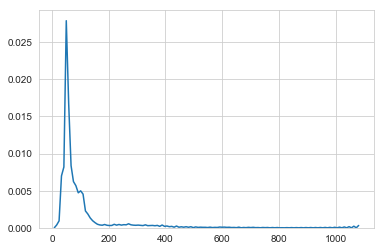

In [24]:
data = df.Appliances
sns.set_style('whitegrid')
sns.kdeplot(np.array(data), bw=0.5)

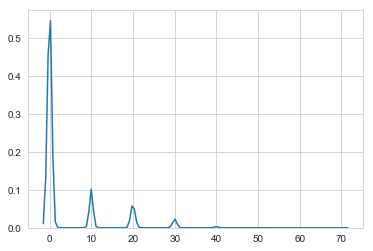

In [25]:
#data = df.lights
sns.set_style('whitegrid')
sns.kdeplot(np.array(df.lights), bw=0.5)

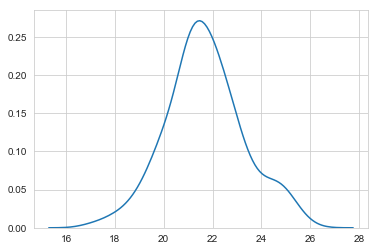

In [26]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(df.T1), bw=0.5)

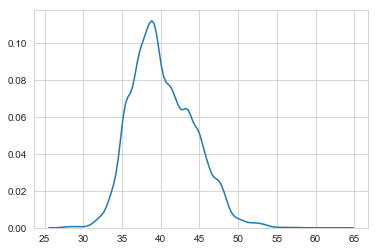

In [27]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(df.RH_1), bw=0.5)

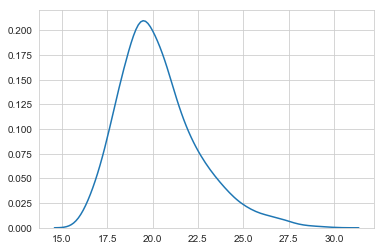

In [28]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(df.T2), bw=0.5)

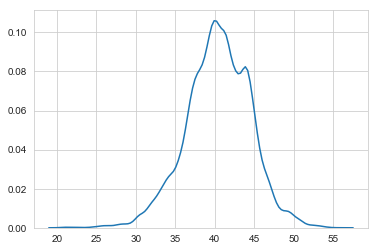

In [29]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(df.RH_2), bw=0.5)

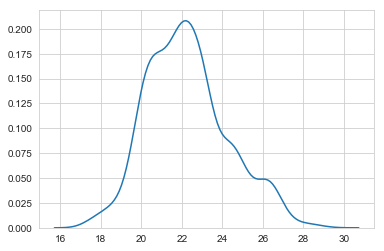

In [30]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(df.T3), bw=0.5)

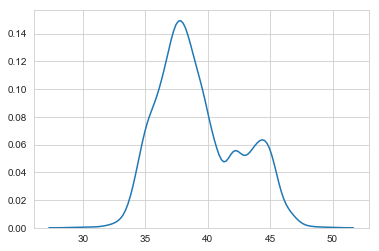

In [31]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(df.RH_3), bw=0.5)

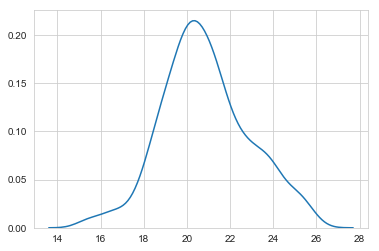

In [32]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(df.T4), bw=0.5)

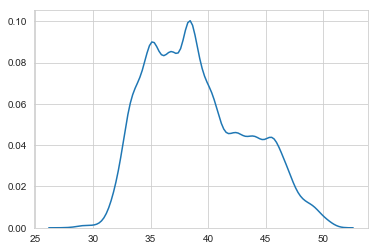

In [33]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(df.RH_4), bw=0.5)

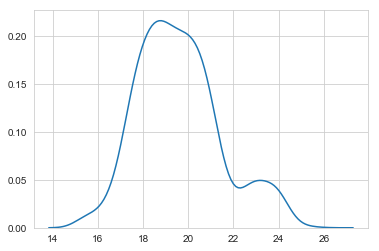

In [34]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(df.T5), bw=0.5)

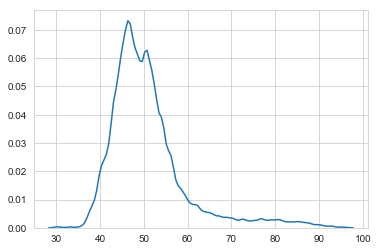

In [35]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(df.RH_5), bw=0.5)

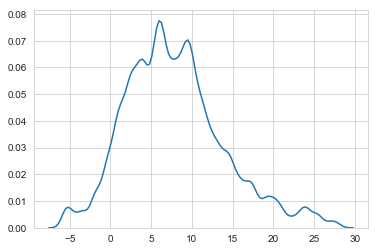

In [36]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(df.T6), bw=0.5)

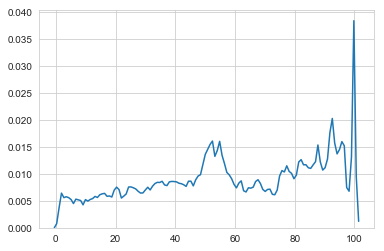

In [37]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(df.RH_6), bw=0.5)

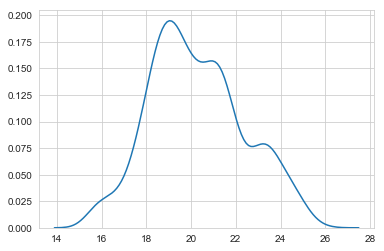

In [38]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(df.T7), bw=0.5)

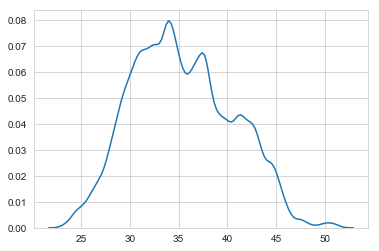

In [39]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(df.RH_7), bw=0.5)

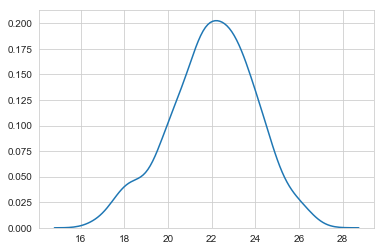

In [40]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(df.T8), bw=0.5)

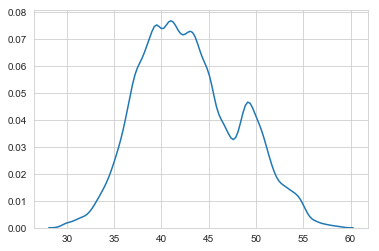

In [41]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(df.RH_8), bw=0.5)

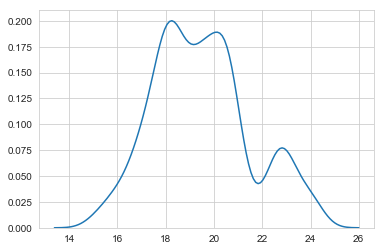

In [42]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(df.T9), bw=0.5)

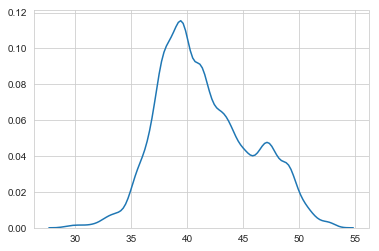

In [43]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(df.RH_9), bw=0.5)

In [44]:
df.fecha.head()

date
2016-01-11 17:00:00   2016-01-11 17:00:00
2016-01-11 17:10:00   2016-01-11 17:10:00
2016-01-11 17:20:00   2016-01-11 17:20:00
2016-01-11 17:40:00   2016-01-11 17:40:00
2016-01-11 17:50:00   2016-01-11 17:50:00
Name: fecha, dtype: datetime64[ns]

### Plots to check the association between two variables

In [45]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

df_plot=pd.DataFrame({'x': np.array(df['fecha']), 'y': np.array(df.Appliances)})
#df_plot=df_plot.sort_values("x", axis = 0, ascending = True, 
#                 inplace = True, na_position ='last') 
print(df_plot)

                        x    y
0     2016-01-11 17:00:00   60
1     2016-01-11 17:10:00   60
2     2016-01-11 17:20:00   50
3     2016-01-11 17:40:00   60
4     2016-01-11 17:50:00   50
5     2016-01-11 18:10:00   60
6     2016-01-11 18:20:00   60
7     2016-01-11 18:30:00   70
8     2016-01-11 19:00:00  430
9     2016-01-11 19:10:00  250
10    2016-01-11 19:20:00  100
11    2016-01-11 19:40:00   90
12    2016-01-11 20:00:00   80
13    2016-01-11 20:10:00  140
14    2016-01-11 20:20:00  120
15    2016-01-11 20:50:00  110
16    2016-01-11 21:00:00  110
17    2016-01-11 21:10:00  110
18    2016-01-11 21:20:00  100
19    2016-01-11 21:40:00  100
20    2016-01-11 21:50:00  100
21    2016-01-11 22:00:00  110
22    2016-01-11 22:10:00  400
23    2016-01-11 22:20:00  400
24    2016-01-11 22:30:00  390
25    2016-01-11 22:40:00  240
26    2016-01-11 23:00:00   60
27    2016-01-11 23:10:00   60
28    2016-01-11 23:20:00   50
29    2016-01-11 23:30:00   70
...                   ...  ...
19705 20

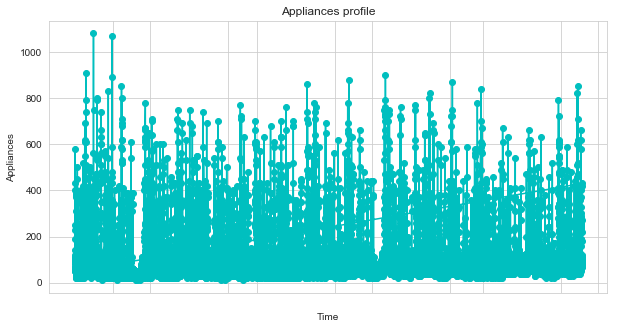

In [46]:
# plot with matplotlib

plt.figure(figsize=(10,5))
df_plot=pd.DataFrame({'x': np.array(df.loc[:,'fecha']), 'y': np.array(df.loc[:,'Appliances'])})
plt.xlabel('Time')
plt.ylabel('Appliances')
plt.title('Appliances profile')
plt.axis('on')
plt.xticks(color='w')
plt.plot( 'x', 'y', 'c', data=df_plot, marker='o')
plt.show()


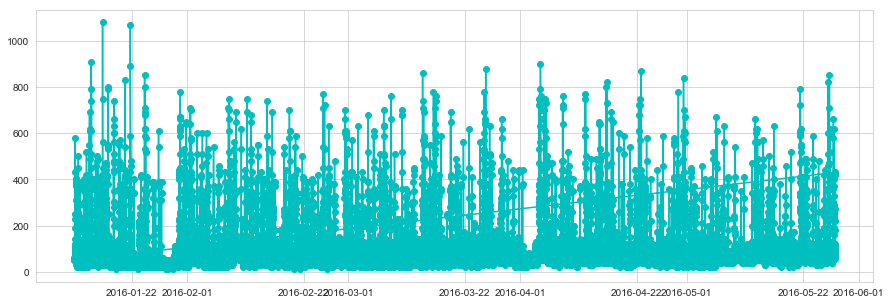

In [47]:
# Create data
plt.figure(figsize=(15,5))
#df_plot=pd.DataFrame({'x': np.array(df['fecha'].dt.strftime("%W")), 'y': np.array(df.Appliances)})
df_plot=pd.DataFrame({'x': np.array(df.loc[:,'fecha']), 'y': np.array(df.loc[:,'Appliances'])})
 
# plot with matplotlib
plt.plot( 'x', 'y', 'c', data=df_plot, marker='o')
plt.show()

In [48]:
### Feature distribution analysis

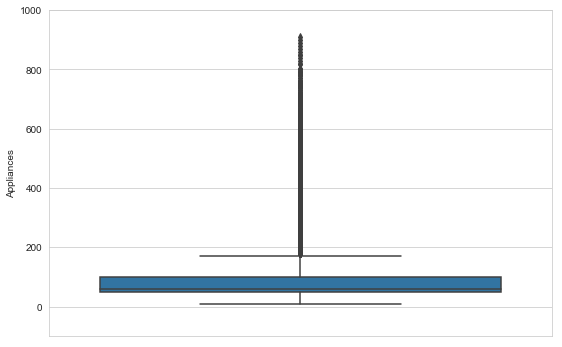

In [49]:
# Create the boxplot
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.boxplot(y="Appliances", data=df)

# Set the `xlim`
ax.set(ylim=(-100, 1000))

# Show the plot
plt.show()

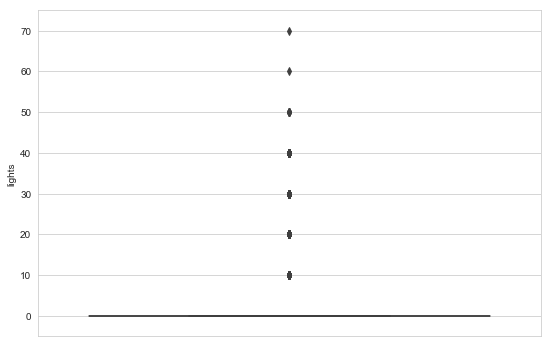

In [50]:
# Create the boxplot
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.boxplot(y="lights", data=df)
# Set the `xlim`
ax.set(ylim=(-5, 75))
# Show the plot
plt.show()

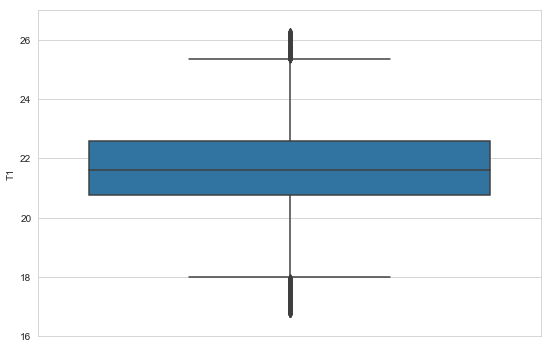

In [51]:
# Create the boxplot
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.boxplot(y="T1", data=df)
# Set the `xlim`
ax.set(ylim=(16, 27))
# Show the plot
plt.show()

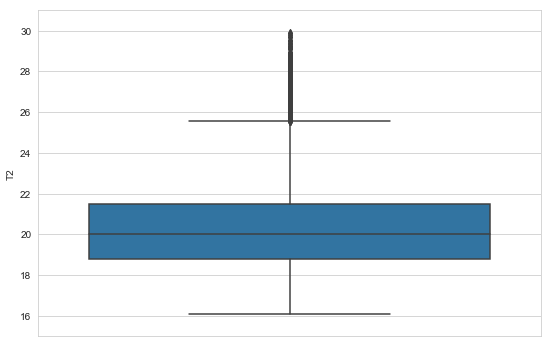

In [52]:
# Create the boxplot
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.boxplot(y="T2", data=df)
# Set the `xlim`
ax.set(ylim=(15, 31))
# Show the plot
plt.show()

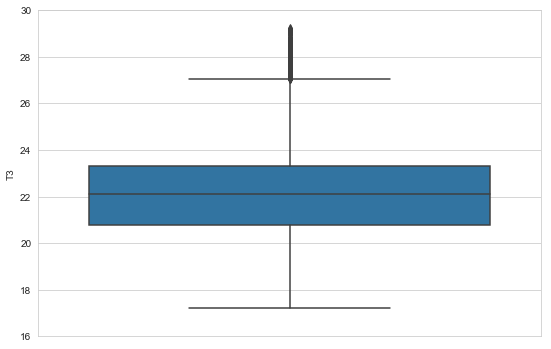

In [53]:
# Create the boxplot
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.boxplot(y="T3", data=df)
# Set the `xlim`
ax.set(ylim=(16, 30))
# Show the plot
plt.show()

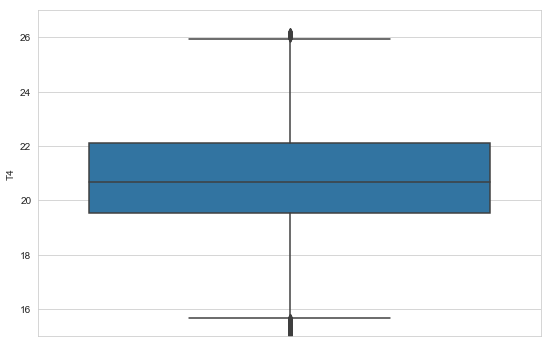

In [54]:
# Create the boxplot
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.boxplot(y="T4", data=df)
# Set the `xlim`
ax.set(ylim=(15, 27))
# Show the plot
plt.show()

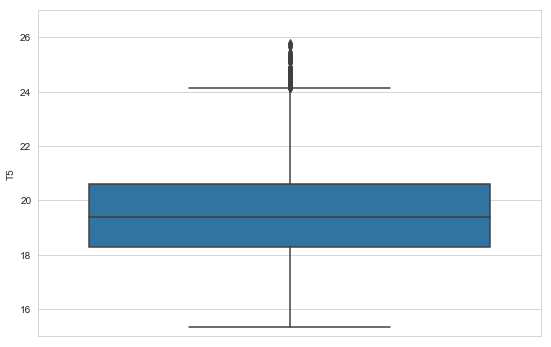

In [55]:
# Create the boxplot
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.boxplot(y="T5", data=df)
# Set the `xlim`
ax.set(ylim=(15, 27))
# Show the plot
plt.show()

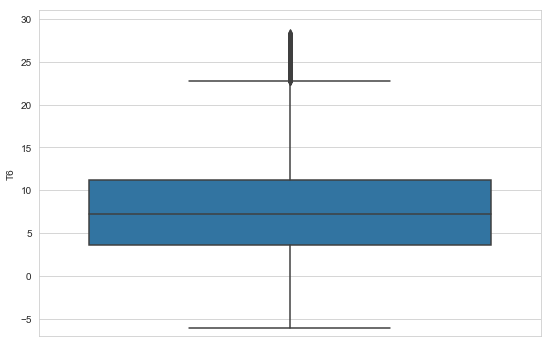

In [56]:
# Create the boxplot
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.boxplot(y="T6", data=df)
# Set the `xlim`
ax.set(ylim=(-7, 31))
# Show the plot
plt.show()

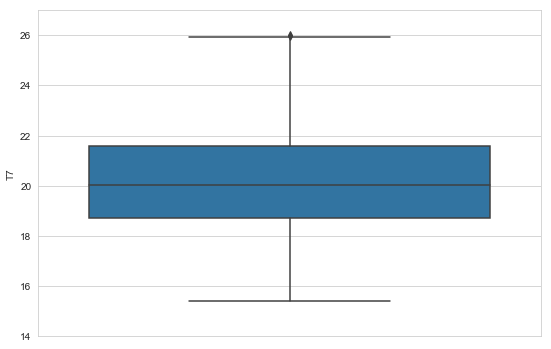

In [57]:
# Create the boxplot
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.boxplot(y="T7", data=df)
# Set the `xlim`
ax.set(ylim=(14, 27))
# Show the plot
plt.show()

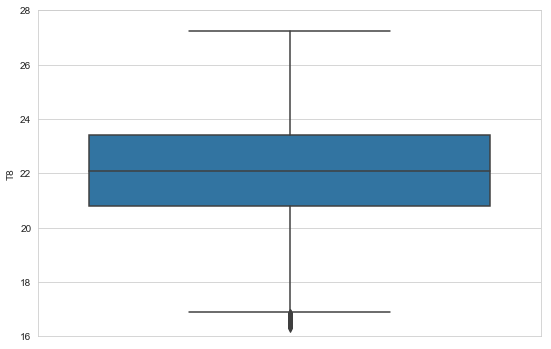

In [58]:
# Create the boxplot
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.boxplot(y="T8", data=df)
# Set the `xlim`
ax.set(ylim=(16, 28))
# Show the plot
plt.show()

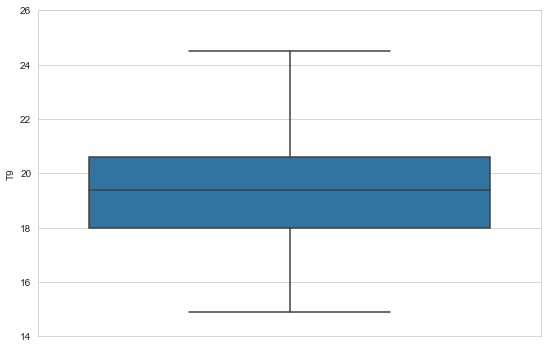

In [59]:
# Create the boxplot
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.boxplot(y="T9", data=df)
# Set the `xlim`
ax.set(ylim=(14, 26))
# Show the plot
plt.show()

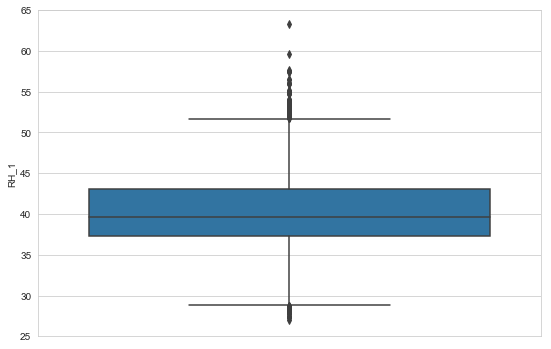

In [60]:
# Create the boxplot
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.boxplot(y="RH_1", data=df)
# Set the `xlim`
ax.set(ylim=(25, 65))
# Show the plot
plt.show()

In [61]:
# calcula NSM; segundos de date
# WeekStatus; indica si es un fin de semana
# Day_of_week; día de la semana

In [62]:
# Energy usage by week and month and hour representation
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 17:40:00
Data columns (total 32 columns):
Appliances     19735 non-null int64
lights         19735 non-null int64
T1             19735 non-null float64
RH_1           19735 non-null float64
T2             19735 non-null float64
RH_2           19735 non-null float64
T3             19735 non-null float64
RH_3           19735 non-null float64
T4             19735 non-null float64
RH_4           19735 non-null float64
T5             19735 non-null float64
RH_5           19735 non-null float64
T6             19735 non-null float64
RH_6           19735 non-null float64
T7             19735 non-null float64
RH_7           19735 non-null float64
T8             19735 non-null float64
RH_8           19735 non-null float64
T9             19735 non-null float64
RH_9           19735 non-null float64
T_out          19735 non-null float64
Press_mm_hg    19735 non-null float64
RH_out         19735 non

In [63]:
df['month'] = df['fecha'].astype('datetime64[M]')
df['mhm']   = df['fecha'].astype('datetime64[h]')

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 17:40:00
Data columns (total 34 columns):
Appliances     19735 non-null int64
lights         19735 non-null int64
T1             19735 non-null float64
RH_1           19735 non-null float64
T2             19735 non-null float64
RH_2           19735 non-null float64
T3             19735 non-null float64
RH_3           19735 non-null float64
T4             19735 non-null float64
RH_4           19735 non-null float64
T5             19735 non-null float64
RH_5           19735 non-null float64
T6             19735 non-null float64
RH_6           19735 non-null float64
T7             19735 non-null float64
RH_7           19735 non-null float64
T8             19735 non-null float64
RH_8           19735 non-null float64
T9             19735 non-null float64
RH_9           19735 non-null float64
T_out          19735 non-null float64
Press_mm_hg    19735 non-null float64
RH_out         19735 non

In [65]:
# Energy usage per hour
rr=df.groupby('mhm').sum().Appliances

In [66]:
rr

mhm
2016-01-11 17:00:00     330
2016-01-11 18:00:00    1060
2016-01-11 19:00:00    1040
2016-01-11 20:00:00     750
2016-01-11 21:00:00     620
2016-01-11 22:00:00    1600
2016-01-11 23:00:00     340
2016-01-12 00:00:00     850
2016-01-12 01:00:00    1010
2016-01-12 02:00:00     270
2016-01-12 03:00:00     210
2016-01-12 04:00:00     270
2016-01-12 05:00:00     260
2016-01-12 06:00:00     240
2016-01-12 07:00:00     340
2016-01-12 08:00:00     520
2016-01-12 09:00:00     260
2016-01-12 10:00:00    1380
2016-01-12 11:00:00     330
2016-01-12 12:00:00    1120
2016-01-12 13:00:00     910
2016-01-12 14:00:00     820
2016-01-12 15:00:00     220
2016-01-12 16:00:00     240
2016-01-12 17:00:00    1310
2016-01-12 18:00:00     350
2016-01-12 19:00:00     330
2016-01-12 20:00:00     310
2016-01-12 21:00:00     250
2016-01-12 22:00:00     280
                       ... 
2016-05-26 13:00:00     450
2016-05-26 14:00:00     410
2016-05-26 15:00:00     370
2016-05-26 16:00:00    2970
2016-05-26 17:00

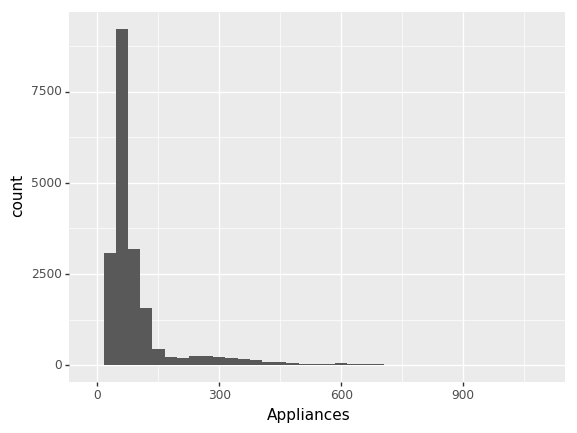

<ggplot: (-9223372036839627120)>

In [67]:
import plotnine as p9

(p9.ggplot(data=df,mapping=p9.aes(x='Appliances')) + p9.geom_histogram(binwidth=30))

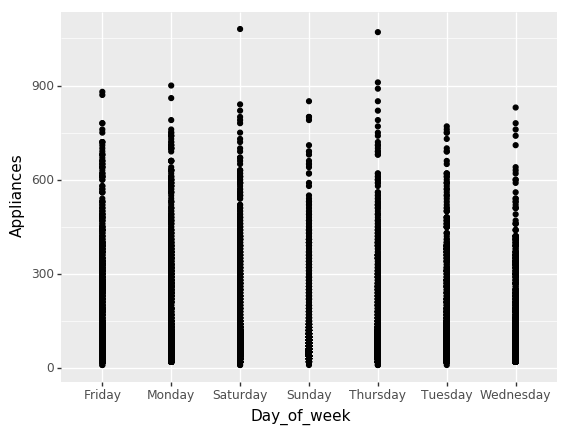

<ggplot: (17621224)>

In [68]:
(p9.ggplot(data=df,mapping=p9.aes(x='Day_of_week',y='Appliances')) + p9.geom_point())
#(p9.ggplot(data=df,mapping=p9.aes(x='Day_of_week',y='Appliances',fill='mhm')) + p9.geom_point())

In [69]:
df.loc[:,['Appliances','Day_of_week']].head(100)

,Appliances,Day_of_week
date,,
2016-01-11 17:00:00,60,Monday
2016-01-11 17:10:00,60,Monday
2016-01-11 17:20:00,50,Monday
2016-01-11 17:40:00,60,Monday
2016-01-11 17:50:00,50,Monday
2016-01-11 18:10:00,60,Monday
2016-01-11 18:20:00,60,Monday
2016-01-11 18:30:00,70,Monday
2016-01-11 19:00:00,430,Monday


In [70]:
df.loc[:,['NSM','WeekStatus','Day_of_week','month','mhm']].head(100)

,NSM,WeekStatus,Day_of_week,month,mhm
date,,,,,
2016-01-11 17:00:00,61200,Weekday,Monday,2016-01-01,2016-01-11 17:00:00
2016-01-11 17:10:00,61800,Weekday,Monday,2016-01-01,2016-01-11 17:00:00
2016-01-11 17:20:00,62400,Weekday,Monday,2016-01-01,2016-01-11 17:00:00
2016-01-11 17:40:00,63600,Weekday,Monday,2016-01-01,2016-01-11 17:00:00
2016-01-11 17:50:00,64200,Weekday,Monday,2016-01-01,2016-01-11 17:00:00
2016-01-11 18:10:00,65400,Weekday,Monday,2016-01-01,2016-01-11 18:00:00
2016-01-11 18:20:00,66000,Weekday,Monday,2016-01-01,2016-01-11 18:00:00
2016-01-11 18:30:00,66600,Weekday,Monday,2016-01-01,2016-01-11 18:00:00
2016-01-11 19:00:00,68400,Weekday,Monday,2016-01-01,2016-01-11 19:00:00


In [71]:
df.loc[(df['Day_of_week']=='Monday') & (df['NSM']>=65000),['NSM','WeekStatus','Day_of_week','month','mhm']]

,NSM,WeekStatus,Day_of_week,month,mhm
date,,,,,
2016-01-11 18:10:00,65400,Weekday,Monday,2016-01-01,2016-01-11 18:00:00
2016-01-11 18:20:00,66000,Weekday,Monday,2016-01-01,2016-01-11 18:00:00
2016-01-11 18:30:00,66600,Weekday,Monday,2016-01-01,2016-01-11 18:00:00
2016-01-11 19:00:00,68400,Weekday,Monday,2016-01-01,2016-01-11 19:00:00
2016-01-11 19:10:00,69000,Weekday,Monday,2016-01-01,2016-01-11 19:00:00
2016-01-11 19:20:00,69600,Weekday,Monday,2016-01-01,2016-01-11 19:00:00
2016-01-11 19:40:00,70800,Weekday,Monday,2016-01-01,2016-01-11 19:00:00
2016-01-11 20:00:00,72000,Weekday,Monday,2016-01-01,2016-01-11 20:00:00
2016-01-11 20:10:00,72600,Weekday,Monday,2016-01-01,2016-01-11 20:00:00


In [72]:
df.loc[(df['Day_of_week']=='Monday') & (df['NSM']>65000),]

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,Visibility,Tdewpoint,rv1,rv2,NSM,WeekStatus,Day_of_week,fecha,month,mhm
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 18:10:00,60,50,19.856667,45.560000,19.200000,44.500000,19.730000,44.900000,18.890000,45.863333,...,40.000000,4.683333,33.039890,33.039890,65400,Weekday,Monday,2016-01-11 18:10:00,2016-01-01,2016-01-11 18:00:00
2016-01-11 18:20:00,60,40,19.790000,45.597500,19.200000,44.433333,19.730000,44.790000,18.890000,45.790000,...,40.000000,4.666667,31.455702,31.455702,66000,Weekday,Monday,2016-01-11 18:20:00,2016-01-01,2016-01-11 18:00:00
2016-01-11 18:30:00,70,40,19.856667,46.090000,19.230000,44.400000,19.790000,44.863333,18.890000,46.096667,...,40.000000,4.650000,3.089314,3.089314,66600,Weekday,Monday,2016-01-11 18:30:00,2016-01-01,2016-01-11 18:00:00
2016-01-11 19:00:00,430,50,20.133333,48.000000,19.566667,44.400000,19.890000,44.900000,19.000000,46.363333,...,40.000000,4.600000,34.351142,34.351142,68400,Weekday,Monday,2016-01-11 19:00:00,2016-01-01,2016-01-11 19:00:00
2016-01-11 19:10:00,250,40,20.260000,52.726667,19.730000,45.100000,19.890000,45.493333,19.000000,47.223333,...,40.000000,4.516667,19.205186,19.205186,69000,Weekday,Monday,2016-01-11 19:10:00,2016-01-01,2016-01-11 19:00:00
2016-01-11 19:20:00,100,10,20.426667,55.893333,19.856667,45.833333,20.033333,47.526667,19.000000,48.696667,...,40.000000,4.433333,38.492071,38.492071,69600,Weekday,Monday,2016-01-11 19:20:00,2016-01-01,2016-01-11 19:00:00
2016-01-11 19:40:00,90,10,20.730000,52.660000,20.166667,47.223333,20.200000,48.530000,18.926667,48.156667,...,40.000000,4.266667,35.880925,35.880925,70800,Weekday,Monday,2016-01-11 19:40:00,2016-01-01,2016-01-11 19:00:00
2016-01-11 20:00:00,80,30,20.890000,51.193333,20.200000,46.330000,20.200000,48.193333,18.963333,48.630000,...,40.000000,4.100000,19.001759,19.001759,72000,Weekday,Monday,2016-01-11 20:00:00,2016-01-01,2016-01-11 20:00:00
2016-01-11 20:10:00,140,40,20.890000,49.800000,20.200000,46.026667,20.166667,47.633333,19.033333,49.500000,...,40.000000,4.066667,38.872261,38.872261,72600,Weekday,Monday,2016-01-11 20:10:00,2016-01-01,2016-01-11 20:00:00


In [73]:
list(df.columns)

['Appliances',
 'lights',
 'T1',
 'RH_1',
 'T2',
 'RH_2',
 'T3',
 'RH_3',
 'T4',
 'RH_4',
 'T5',
 'RH_5',
 'T6',
 'RH_6',
 'T7',
 'RH_7',
 'T8',
 'RH_8',
 'T9',
 'RH_9',
 'T_out',
 'Press_mm_hg',
 'RH_out',
 'Windspeed',
 'Visibility',
 'Tdewpoint',
 'rv1',
 'rv2',
 'NSM',
 'WeekStatus',
 'Day_of_week',
 'fecha',
 'month',
 'mhm']

In [74]:
# heat map to understand the usage pattern

df['my'] = df['month']
df['mhr'] = df['mhm']
del df['month']
del df['mhm']

In [75]:

energy_usage_total_per_hour = df.groupby(['mhr'])['Appliances'].agg('sum')
energy_usage_total_per_hour = energy_usage_total_per_hour.to_frame() 
energy_usage_total_per_hour.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3290 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 1 columns):
Appliances    3290 non-null int64
dtypes: int64(1)
memory usage: 51.4 KB


In [76]:
list(energy_usage_total_per_hour.columns)

['Appliances']

In [77]:
energy_usage_total_per_hour

,Appliances
mhr,
2016-01-11 17:00:00,330
2016-01-11 18:00:00,1060
2016-01-11 19:00:00,1040
2016-01-11 20:00:00,750
2016-01-11 21:00:00,620
2016-01-11 22:00:00,1600
2016-01-11 23:00:00,340
2016-01-12 00:00:00,850
2016-01-12 01:00:00,1010


In [78]:

energy_usage_total_per_hour['Day_week'] = pd.DatetimeIndex(energy_usage_total_per_hour.index.values).strftime('%a')
energy_usage_total_per_hour.head()

,Appliances,Day_week
mhr,,
2016-01-11 17:00:00,330,Mon
2016-01-11 18:00:00,1060,Mon
2016-01-11 19:00:00,1040,Mon
2016-01-11 20:00:00,750,Mon
2016-01-11 21:00:00,620,Mon


In [79]:

energy_data = df_train.append(df_test)
energy_data.set_index(pd.DatetimeIndex(energy_data['date']), inplace = True)
energy_data.drop(['date'], axis=1, inplace=True)
energy_data.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM,WeekStatus,Day_of_week
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,61200,Weekday,Monday
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,61800,Weekday,Monday
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,62400,Weekday,Monday
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,63600,Weekday,Monday
2016-01-11 17:50:00,50,40,19.89,46.026667,19.2,44.500000,19.79,44.933333,18.890000,45.730000,...,734.0,92.0,5.333333,43.833333,4.8,44.919484,44.919484,64200,Weekday,Monday


In [80]:
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 17:40:00
Data columns (total 31 columns):
Appliances     19735 non-null int64
lights         19735 non-null int64
T1             19735 non-null float64
RH_1           19735 non-null float64
T2             19735 non-null float64
RH_2           19735 non-null float64
T3             19735 non-null float64
RH_3           19735 non-null float64
T4             19735 non-null float64
RH_4           19735 non-null float64
T5             19735 non-null float64
RH_5           19735 non-null float64
T6             19735 non-null float64
RH_6           19735 non-null float64
T7             19735 non-null float64
RH_7           19735 non-null float64
T8             19735 non-null float64
RH_8           19735 non-null float64
T9             19735 non-null float64
RH_9           19735 non-null float64
T_out          19735 non-null float64
Press_mm_hg    19735 non-null float64
RH_out         19735 non

Text(0.5, 1.0, 'Appliances profile')

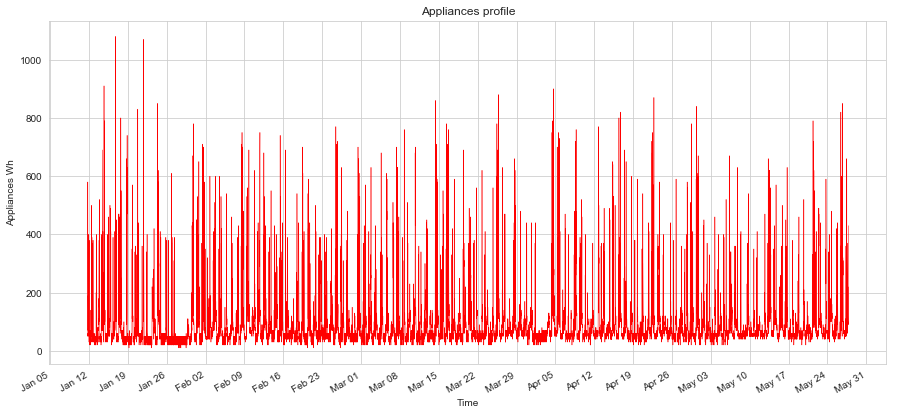

In [81]:
# Plotting the Appliances profile
#
import matplotlib.dates as mdates
%matplotlib inline

#plot data
fig, ax = plt.subplots(figsize=(15,7))
energy_data['Appliances'].plot(ax=ax, color='red', figsize=(15,7), kind='line', lw=0.5)

#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.xlabel('Time')
plt.ylabel('Appliances Wh')
plt.title('Appliances profile')

Text(0.5, 1.0, 'Appliances profile')

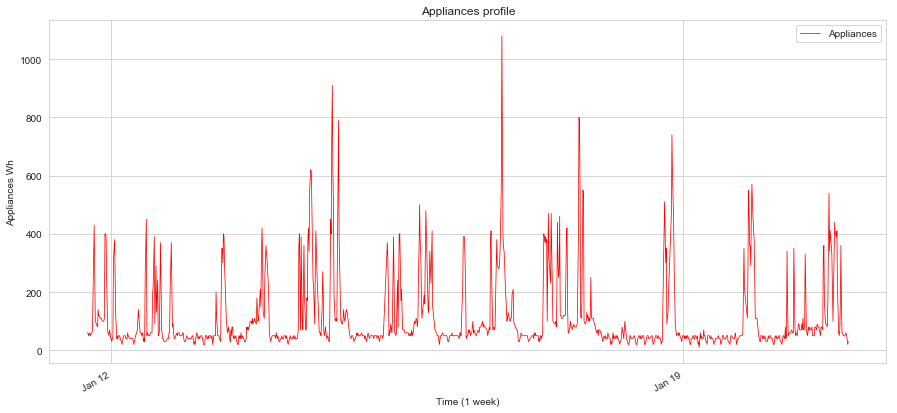

In [82]:
import matplotlib.dates as mdates
%matplotlib inline

#plot data
fig, ax = plt.subplots(figsize=(15,7))
energy_data.iloc[0:1008, 0:1].plot(ax=ax, color='red', kind='line', lw=0.75)

#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.xlabel('Time (1 week)')
plt.ylabel('Appliances Wh')
plt.title('Appliances profile')

In [83]:
# HEAT MAP visualization
# Visualization of the Energy use per week with heat map
energy_data['my'] = energy_data.index.values.astype('datetime64[M]')
energy_data['mhr'] = energy_data.index.values.astype('datetime64[h]')

In [84]:
energy_data_Total_per_hour = energy_data.groupby(['mhr'])['Appliances'].agg('sum').to_frame()
energy_data_Total_per_hour['Day_week']  = pd.DatetimeIndex(energy_data_Total_per_hour.index.values).strftime('%w')
energy_data_Total_per_hour['week_year'] = pd.DatetimeIndex(energy_data_Total_per_hour.index.values).strftime('%U')
energy_data_Total_per_hour['Hour']      = pd.DatetimeIndex(energy_data_Total_per_hour.index.values).strftime('%H')
energy_data_Total_per_hour


,Appliances,Day_week,week_year,Hour
mhr,,,,
2016-01-11 17:00:00,330,1,02,17
2016-01-11 18:00:00,1060,1,02,18
2016-01-11 19:00:00,1040,1,02,19
2016-01-11 20:00:00,750,1,02,20
2016-01-11 21:00:00,620,1,02,21
2016-01-11 22:00:00,1600,1,02,22
2016-01-11 23:00:00,340,1,02,23
2016-01-12 00:00:00,850,2,02,00
2016-01-12 01:00:00,1010,2,02,01


In [85]:
replace_Nan_object(energy_data_Total_per_hour)

['Day_week', 'week_year', 'Hour']


In [86]:
energy_data_Total_per_hour.dropna()

,Appliances,Day_week,week_year,Hour
mhr,,,,
2016-01-11 17:00:00,330,1,02,17
2016-01-11 18:00:00,1060,1,02,18
2016-01-11 19:00:00,1040,1,02,19
2016-01-11 20:00:00,750,1,02,20
2016-01-11 21:00:00,620,1,02,21
2016-01-11 22:00:00,1600,1,02,22
2016-01-11 23:00:00,340,1,02,23
2016-01-12 00:00:00,850,2,02,00
2016-01-12 01:00:00,1010,2,02,01


In [87]:
# first week only
#energy_data_Total_per_hour_na_removed_w1 <- energy_data_Total_per_hour_na_removed[energy_data_Total_per_hour_na_removed$week_year ==3,]
#energy_data_Total_per_hour_na_removed_w1
#energy_data_Total_per_hour_na_removed_w1$Hour <- hour(energy_data_Total_per_hour_na_removed_w1$mhr)
#names(energy_data_Total_per_hour_na_removed_w1)

energy_data_Total_per_hour_na_removed_w1=energy_data_Total_per_hour.loc[(energy_data_Total_per_hour['week_year']=='02'),:]
energy_data_Total_per_hour_na_removed_w1

,Appliances,Day_week,week_year,Hour
mhr,,,,
2016-01-11 17:00:00,330,1,02,17
2016-01-11 18:00:00,1060,1,02,18
2016-01-11 19:00:00,1040,1,02,19
2016-01-11 20:00:00,750,1,02,20
2016-01-11 21:00:00,620,1,02,21
2016-01-11 22:00:00,1600,1,02,22
2016-01-11 23:00:00,340,1,02,23
2016-01-12 00:00:00,850,2,02,00
2016-01-12 01:00:00,1010,2,02,01


### Heatmaps

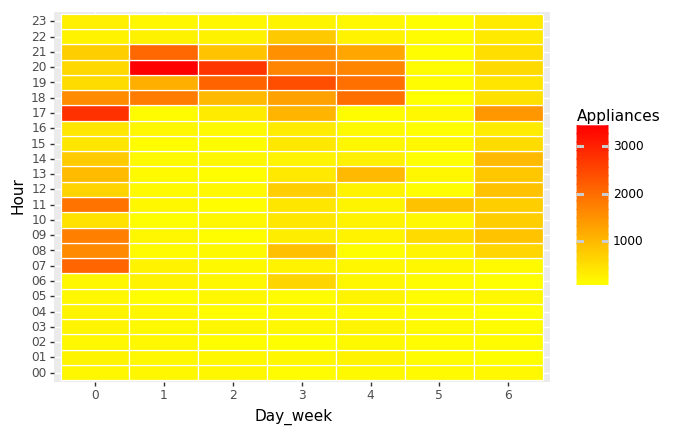

<ggplot: (18006862)>

In [88]:
#dff=energy_data_Total_per_hour_na_removed_w1
dff=energy_data_Total_per_hour.loc[(energy_data_Total_per_hour['week_year']=='03'),:]
(p9.ggplot(data=dff,mapping=p9.aes(x='Day_week',y='Hour',fill='Appliances'))+p9.geom_tile(color="white", size=0.50)+p9.scale_fill_gradient(low="yellow", high="red"))

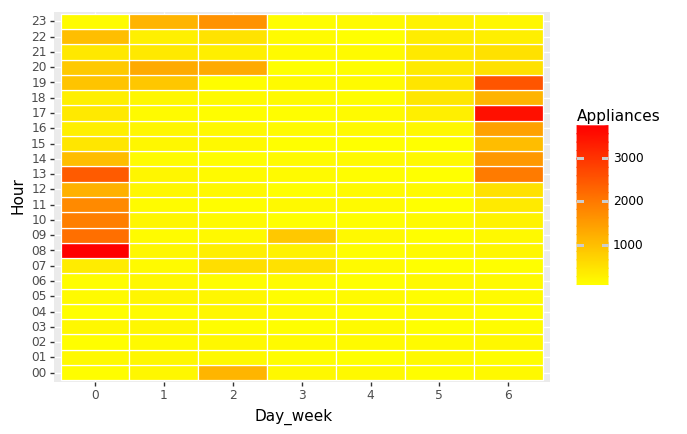

<ggplot: (18007886)>

In [89]:
dff=energy_data_Total_per_hour.loc[(energy_data_Total_per_hour['week_year']=='04'),:]
(p9.ggplot(data=dff,mapping=p9.aes(x='Day_week',y='Hour',fill='Appliances'))+p9.geom_tile(color="white", size=0.50)+p9.scale_fill_gradient(low="yellow", high="red"))

In [90]:
print(df_train.head())

                  date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
1  2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2  2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
3  2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   
4  2016-01-11 17:50:00          50      40  19.89  46.026667  19.2  44.500000   

      T3       RH_3         T4     ...       Press_mm_hg  RH_out  Windspeed  \
0  19.79  44.730000  19.000000     ...             733.5    92.0   7.000000   
1  19.79  44.790000  19.000000     ...             733.6    92.0   6.666667   
2  19.79  44.933333  18.926667     ...             733.7    92.0   6.333333   
3  19.79  45.000000  18.890000     ...             733.9    92.0   5.666667   
4  19.79  44.933333  18.890000     ...             734.0    92.0   5.333333   

   Visibility  Tdewpoint        rv1   

### Correlation Matrix

   Appliances  lights     T1       RH_1    T2       RH_2     T3       RH_3
0          60      30  19.89  47.596667  19.2  44.790000  19.79  44.730000
1          60      30  19.89  46.693333  19.2  44.722500  19.79  44.790000
2          50      30  19.89  46.300000  19.2  44.626667  19.79  44.933333
3          60      40  19.89  46.333333  19.2  44.530000  19.79  45.000000
4          50      40  19.89  46.026667  19.2  44.500000  19.79  44.933333


<Figure size 432x288 with 0 Axes>

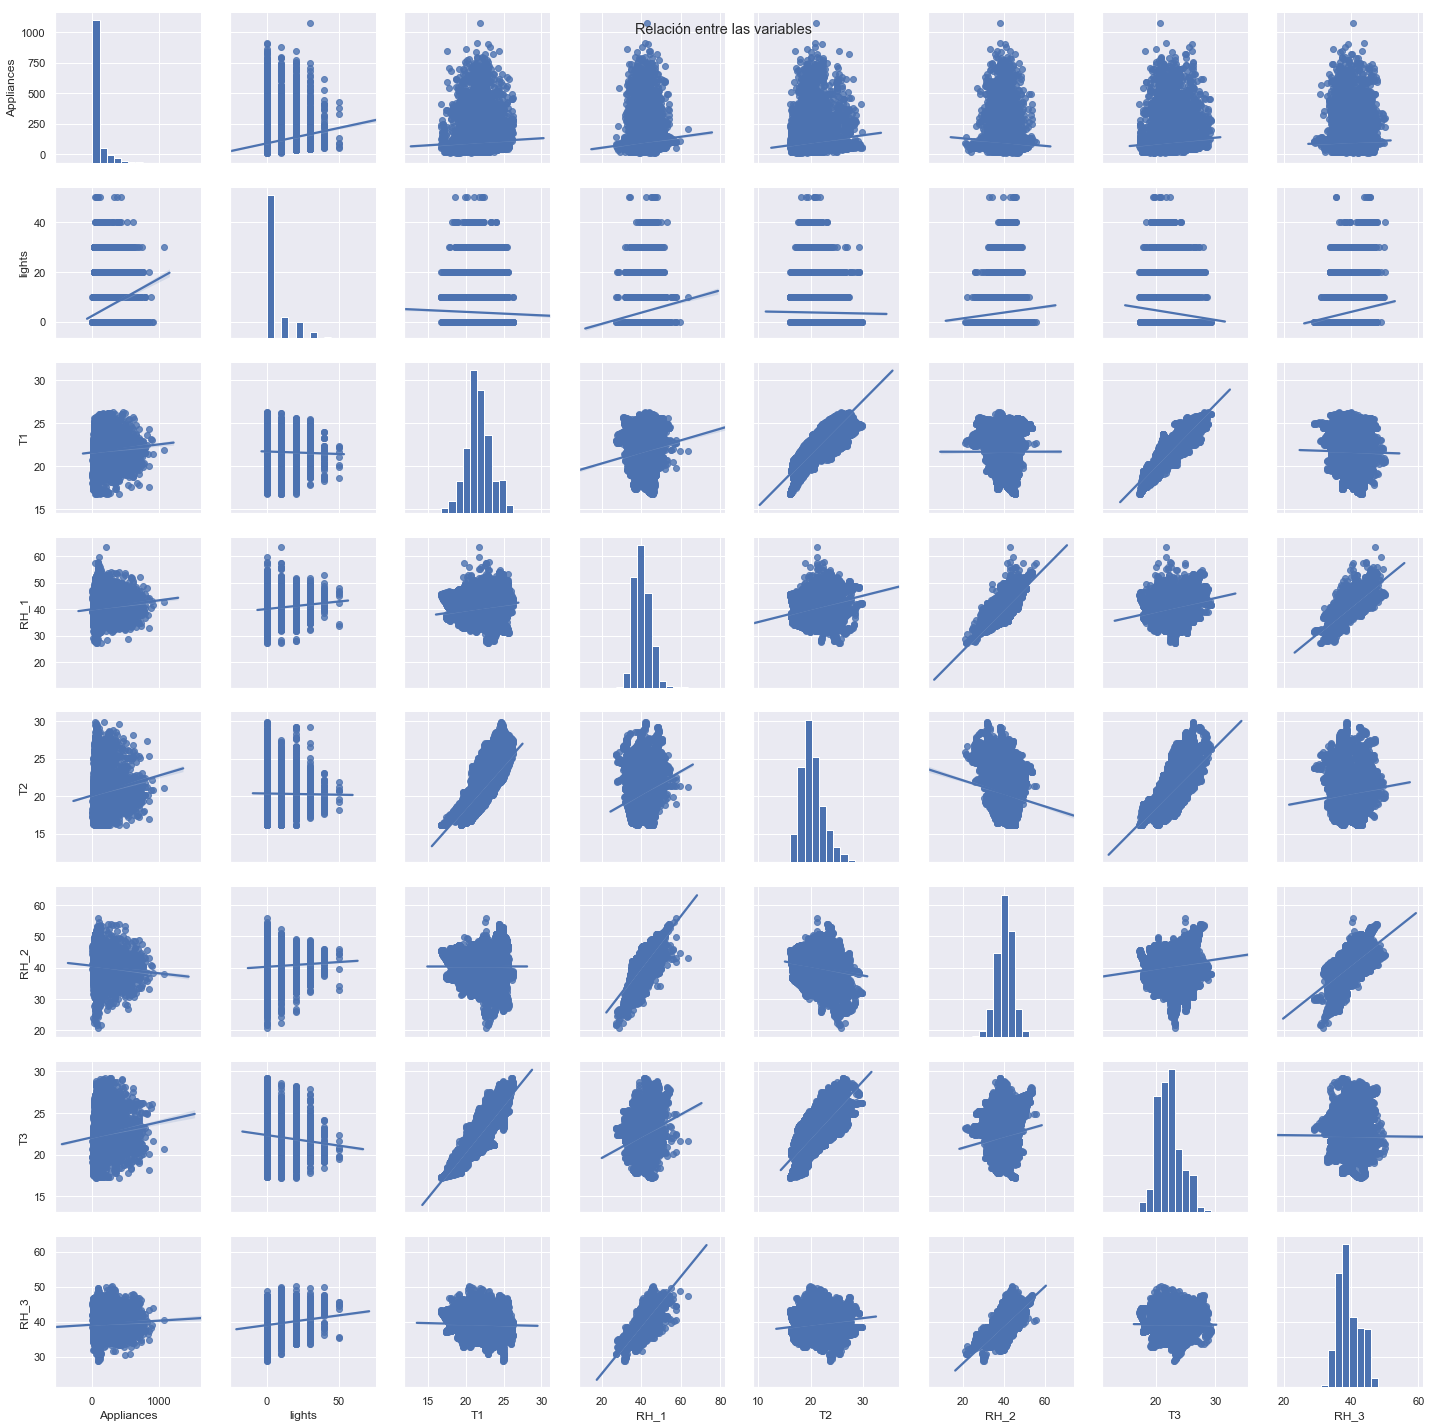

In [91]:
import seaborn as sb
%matplotlib inline
sb.set()
    
traindf=pd.DataFrame(df_train.loc[:,['Appliances', 'lights', \
                                     'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3']])   
print(traindf.head())
    
fig=plt.figure()

ax = sb.pairplot(traindf, height=2.5, palette="husl", kind="reg");
ax.fig.suptitle("Relación entre las variables")
    
plt.show()

In [92]:
corr = df_train.corr()
corr


,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM
Appliances,1.000000,0.194689,0.060137,0.087276,0.124719,-0.061108,0.093336,0.036765,0.046992,0.016296,...,-0.050214,0.104490,-0.032222,-0.154931,0.085245,-0.004788,0.019597,-0.012695,-0.012695,0.216167
lights,0.194689,1.000000,-0.028300,0.112602,-0.011521,0.059335,-0.099009,0.135162,-0.009676,0.116257,...,-0.006144,-0.072475,-0.006817,0.070385,0.063341,0.015786,-0.032328,0.000189,0.000189,0.250096
T1,0.060137,-0.028300,1.000000,0.166716,0.837948,0.000574,0.892645,-0.026293,0.876253,0.098859,...,0.072651,0.683881,-0.150184,-0.345950,-0.089516,-0.076881,0.571246,-0.005145,-0.005145,0.179685
RH_1,0.087276,0.112602,0.166716,1.000000,0.273212,0.798149,0.257264,0.845261,0.110630,0.881178,...,0.765023,0.342619,-0.294802,0.274696,0.203709,-0.014101,0.641863,-0.001888,-0.001888,0.021377
T2,0.124719,-0.011521,0.837948,0.273212,1.000000,-0.160643,0.736325,0.123498,0.763696,0.233459,...,0.160341,0.793605,-0.132267,-0.503849,0.050900,-0.070102,0.584014,-0.009475,-0.009475,0.254604
RH_2,-0.061108,0.059335,0.000574,0.798149,-0.160643,1.000000,0.141735,0.680792,-0.043806,0.722716,...,0.677231,0.036139,-0.258329,0.583899,0.070289,0.001993,0.502365,0.004812,0.004812,-0.179071
T3,0.093336,-0.099009,0.892645,0.257264,0.736325,0.141735,1.000000,-0.007733,0.851302,0.125974,...,0.138325,0.701119,-0.189075,-0.282137,-0.101649,-0.100374,0.646986,-0.002125,-0.002125,0.039770
RH_3,0.036765,0.135162,-0.026293,0.845261,0.123498,0.680792,-0.007733,1.000000,-0.135896,0.899931,...,0.835120,0.120395,-0.236754,0.357210,0.263485,0.021949,0.418458,-0.001044,-0.001044,-0.051239
T4,0.046992,-0.009676,0.876253,0.110630,0.763696,-0.043806,0.851302,-0.135896,1.000000,-0.045076,...,-0.022374,0.666830,-0.072807,-0.390391,-0.183969,-0.103900,0.521379,0.000737,0.000737,0.090273
RH_4,0.016296,0.116257,0.098859,0.881178,0.233459,0.722716,0.125974,0.899931,-0.045076,1.000000,...,0.857180,0.294060,-0.252045,0.338655,0.298016,0.009358,0.618949,-0.001612,-0.001612,-0.017396


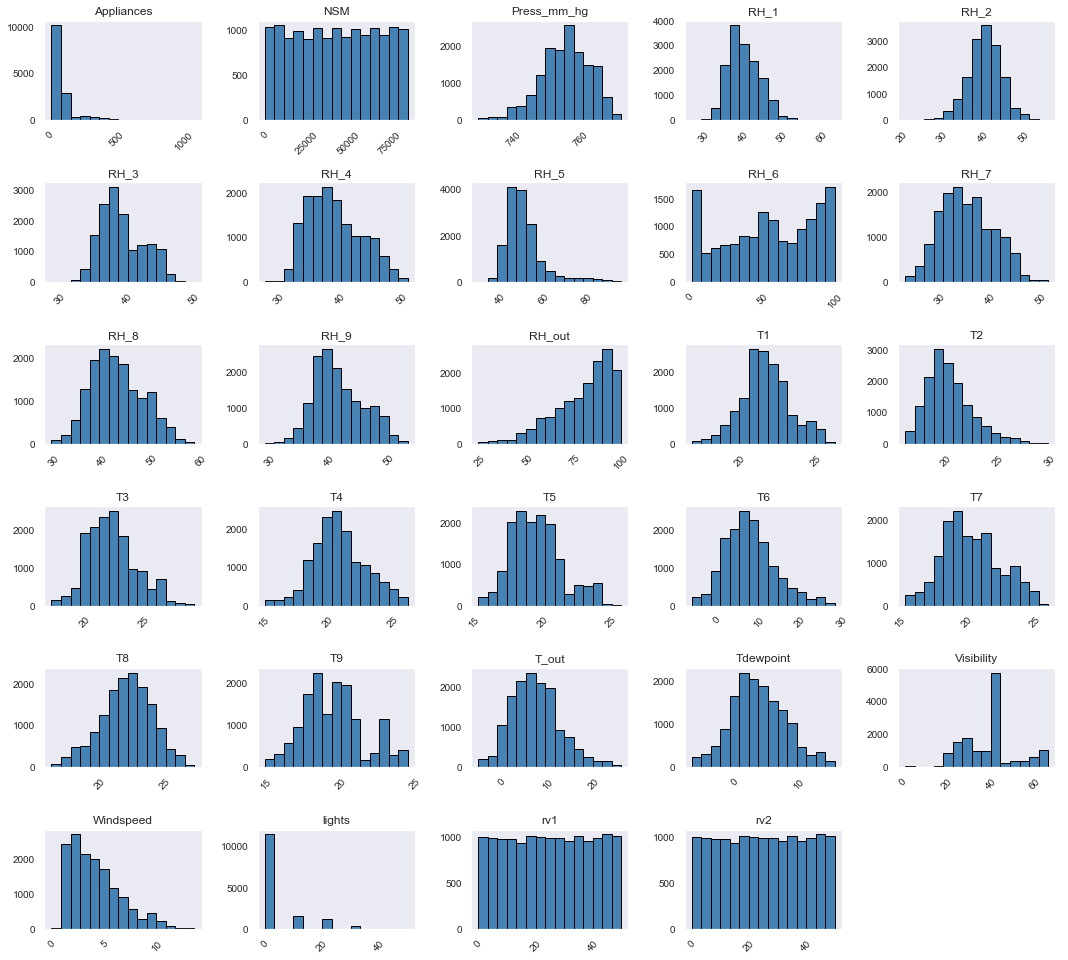

In [93]:
fig = df_train.hist(bins=15,
                 color='steelblue',
                 edgecolor='black', linewidth=1.0,
                 xlabelsize=10, ylabelsize=10,
                 xrot=45, yrot=0,
                 figsize=(10,9),
                 grid=False)

plt.tight_layout(rect=(0, 0, 1.5, 1.5))

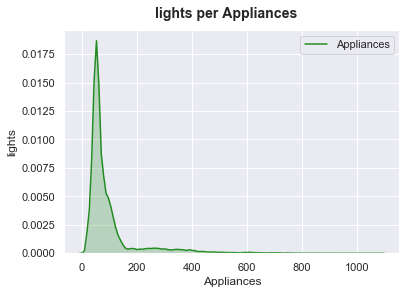

In [94]:
# Prepare the figure
fig = plt.figure( figsize=(6,4) )
title = fig.suptitle("lights per Appliances", fontsize=14, fontweight='bold')
fig.subplots_adjust(top=0.9, wspace=0.3)

# Prepare a subplot
ax1 = fig.add_subplot(111)
ax1.set_xlabel("Appliances")
ax1.set_ylabel("lights") 

# Annotate: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.annotate.html
#ax1.annotate('LOOK HERE!', 
#             xy=(0.5, 3), 
#             xytext=(1.0, 2.0),
#             arrowprops=dict(facecolor='mediumaquamarine')) 

# Seaborn time!
sns.kdeplot(df_train['Appliances'], 
            ax=ax1, 
            shade=True, 
            color='forestgreen')

Text(0.5, 0.98, 'IoT Attributes Correlation Heatmap')

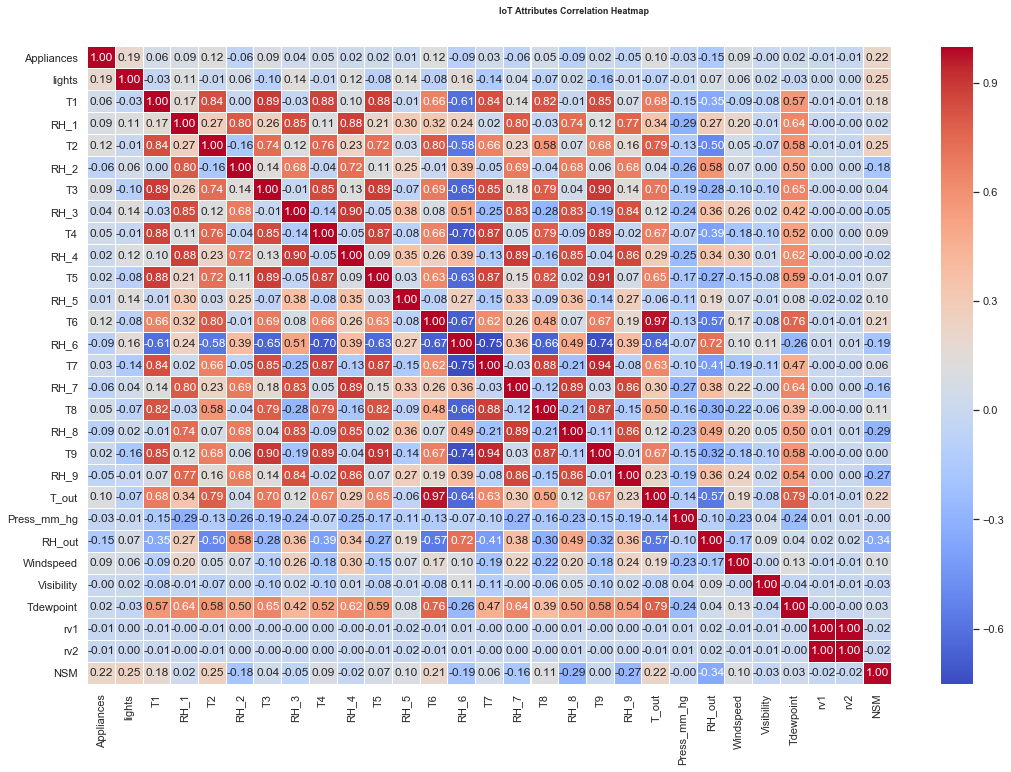

In [95]:
fig, (ax) = plt.subplots(1, 1, figsize=(18,11))

hm = sns.heatmap(corr, 
                 ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap="coolwarm", # Color Map.
                 #square=True,    # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                 annot=True, 
                 fmt='.2f',       # String formatting code to use when adding annotations.
                 #annot_kws={"size": 14},
                 linewidths=.05)

fig.subplots_adjust(top=0.93)
fig.suptitle('IoT Attributes Correlation Heatmap', 
              fontsize=9, 
              fontweight='bold')

In [96]:
energy_data.drop('WeekStatus', axis=1, inplace=True)
energy_data.drop('Day_of_week', axis=1, inplace=True)
  

In [97]:
print(list(energy_data.columns))
print(energy_data.shape)
print(energy_data.head())

['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'NSM', 'my', 'mhr']
(19735, 31)
                     Appliances  lights     T1       RH_1    T2       RH_2  \
date                                                                         
2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   
2016-01-11 17:50:00          50      40  19.89  46.026667  19.2  44.500000   

                        T3       RH_3         T4       RH_4  \
date                                                          
2016-01-11 17:00:00  19.79  44.730000  19.000000  45.566

## Feature Importance with RandomForestClassifier

In [98]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

 
# loading the  dataset
feat_labels=list(energy_data.columns) #names
array=energy_data.values

#x = array[:,0:28]
X = array[:,0:28]
y = array[:,0]
y=y.astype('int')

scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X.astype(float))
#X_test_scale = scaler.transform(X_test)

# Colleting data and target variables
# Split the data into 40% test and 60% training
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.4, random_state=0)
#print(X_train)
#print(y_train)
 
# Create a random forest classifier
rfc = RandomForestClassifier(n_estimators=800,random_state = 0, n_jobs = -1)
#rfc = RandomForestClassifier(n_estimators=800,random_state = 0, n_jobs = -1, max_features=None,min_samples_leaf=1,oob_score=True)
rfc.fit(X_train, y_train)
rfc.feature_importances_
rfc.score(X_train, y_train)

pd.DataFrame(X_train).columns

feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = pd.DataFrame(X_train).columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
#print(feature_importances)
#print(names)

d = []
# Printing the name of each feature along with the gini value
for feature, importance in zip(feat_labels, rfc.feature_importances_):
#    print(feature, importance)
    d.append({'feature': feature, 'importance': importance})

d=pd.DataFrame(d).sort_values('importance',ascending=False)
print(d)

        feature  importance
0    Appliances    0.472752
17         RH_8    0.024000
19         RH_9    0.022588
22       RH_out    0.022474
16           T8    0.022177
11         RH_5    0.022145
12           T6    0.021576
3          RH_1    0.021351
4            T2    0.021266
21  Press_mm_hg    0.021241
13         RH_6    0.020652
26          rv1    0.020632
27          rv2    0.020610
7          RH_3    0.020526
20        T_out    0.020432
15         RH_7    0.020430
25    Tdewpoint    0.020330
5          RH_2    0.020214
9          RH_4    0.019608
8            T4    0.018475
6            T3    0.018170
14           T7    0.018096
10           T5    0.017425
2            T1    0.017325
23    Windspeed    0.016106
18           T9    0.015560
24   Visibility    0.014510
1        lights    0.009327


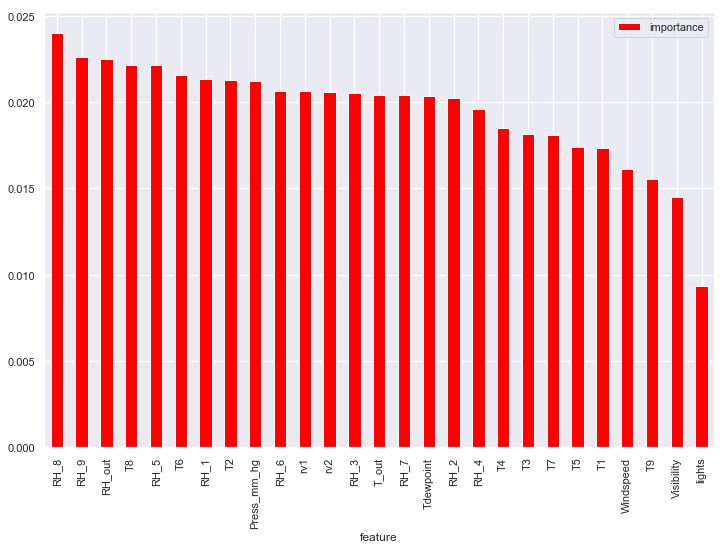

In [99]:
# Plot the feature importances of the forest
d=d.sort_values('importance',ascending=False)
d.iloc[1:28,:].plot(kind='bar',x='feature',y='importance',color='red', figsize=(12,8))
plt.show()

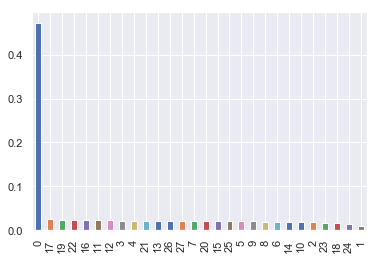

In [100]:
feat_importancesX = pd.Series(rfc.feature_importances_, index=pd.DataFrame(X_train).columns)
feat_importancesX.nlargest(28).plot(kind='bar')

In [101]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.022
sfm = SelectFromModel(rfc, threshold=0.022)

# Train the selector
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=0.022)

In [102]:
# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

Appliances
RH_5
T8
RH_8
RH_9
RH_out


In [103]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [104]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [105]:
from sklearn.metrics import accuracy_score

# Apply The Full Featured Classifier To The Test Data
y_pred = rfc.predict(X_test)

# View The Accuracy Of Our Full Feature (6 Features) Model
accuracy_score(y_test, y_pred)

0.7950342031922979

In [106]:
# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature (2 Features) Model
accuracy_score(y_test, y_important_pred)

0.8790220420572586

In [107]:
X_important_train

array([[0.04672897, 0.12038535, 0.72849732, 0.47855674, 0.63714128,
        0.9122807 ],
       [0.04672897, 0.24185545, 0.51113824, 0.37011652, 0.43163631,
        0.92763158],
       [0.02803738, 0.69708801, 0.41043637, 0.40872744, 0.33374724,
        0.73684211],
       ...,
       [0.06542056, 0.21769031, 0.65421335, 0.42671105, 0.47737307,
        0.50877193],
       [0.03738318, 0.18567061, 0.45926152, 0.2373772 , 0.33774834,
        0.42105263],
       [0.02803738, 0.39702787, 0.40860543, 0.89444825, 0.86230684,
        0.8245614 ]])

In [108]:
y_important_pred

array([390,  50,  50, ...,  60,  70,  50])

In [109]:
y_pred

array([390,  50,  50, ...,  60,  70,  50])

        feature  importance
0    Appliances    0.464013
17         RH_8    0.023669
19         RH_9    0.022708
22       RH_out    0.022615
11         RH_5    0.022484
16           T8    0.021864
4            T2    0.021744
21  Press_mm_hg    0.021580
12           T6    0.021303
3          RH_1    0.021212
27          rv2    0.020836
5          RH_2    0.020764
13         RH_6    0.020756
26          rv1    0.020709
15         RH_7    0.020528
20        T_out    0.020427
7          RH_3    0.020199
25    Tdewpoint    0.020102
9          RH_4    0.019677
6            T3    0.019231
10           T5    0.018970
8            T4    0.018640
2            T1    0.018609
14           T7    0.017544
23    Windspeed    0.017418
18           T9    0.016439
24   Visibility    0.015454
1        lights    0.010503


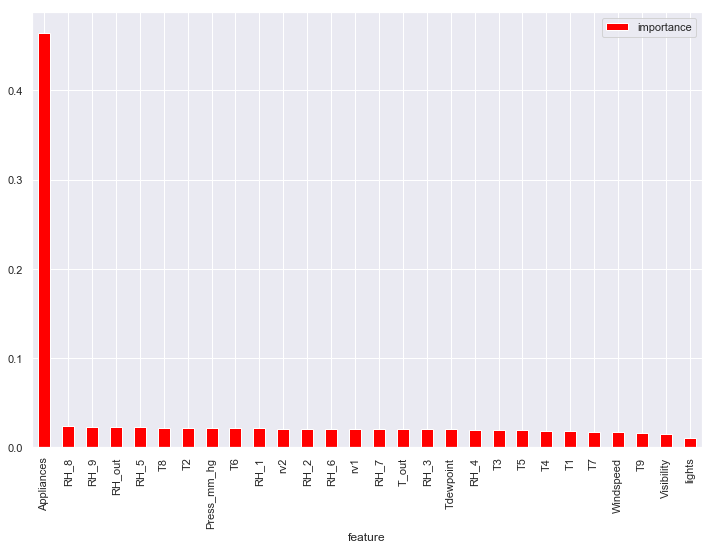

In [110]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
#print(y)
 
# Create a random forest classifier
rfc = RandomForestClassifier(n_estimators=500,random_state = 0, n_jobs = -1)

rfc.fit(X_test, y_test)
rfc.feature_importances_
rfc.score(X_test, y_test)

pd.DataFrame(X_test).columns

feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = pd.DataFrame(X_test).columns, #X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

d2 = []
for feature, importance in zip(energy_data.columns, rfc.feature_importances_):
    d2.append({'feature': feature, 'importance': importance})

d2=pd.DataFrame(d2).sort_values('importance',ascending=False)
print(d2)

# Plot the feature importances of the forest
#d2=d2.sort_values('importance',ascending=False)
d=d2.iloc[1:31,:]
d2.plot(kind='bar',x='feature',y='importance',color='red', figsize=(12,8))
plt.show()

In [111]:
df_train

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM,WeekStatus,Day_of_week
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,...,733.500000,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433,61200,Weekday,Monday
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,733.600000,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195,61800,Weekday,Monday
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,...,733.700000,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668,62400,Weekday,Monday
3,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,733.900000,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097,63600,Weekday,Monday
4,2016-01-11 17:50:00,50,40,19.890000,46.026667,19.200000,44.500000,19.790000,44.933333,18.890000,...,734.000000,92.000000,5.333333,43.833333,4.800000,44.919484,44.919484,64200,Weekday,Monday
5,2016-01-11 18:10:00,60,50,19.856667,45.560000,19.200000,44.500000,19.730000,44.900000,18.890000,...,734.166667,91.833333,5.166667,40.000000,4.683333,33.039890,33.039890,65400,Weekday,Monday
6,2016-01-11 18:20:00,60,40,19.790000,45.597500,19.200000,44.433333,19.730000,44.790000,18.890000,...,734.233333,91.666667,5.333333,40.000000,4.666667,31.455702,31.455702,66000,Weekday,Monday
7,2016-01-11 18:30:00,70,40,19.856667,46.090000,19.230000,44.400000,19.790000,44.863333,18.890000,...,734.300000,91.500000,5.500000,40.000000,4.650000,3.089314,3.089314,66600,Weekday,Monday
8,2016-01-11 19:00:00,430,50,20.133333,48.000000,19.566667,44.400000,19.890000,44.900000,19.000000,...,734.500000,91.000000,6.000000,40.000000,4.600000,34.351142,34.351142,68400,Weekday,Monday
9,2016-01-11 19:10:00,250,40,20.260000,52.726667,19.730000,45.100000,19.890000,45.493333,19.000000,...,734.616667,90.500000,6.000000,40.000000,4.516667,19.205186,19.205186,69000,Weekday,Monday


In [112]:
print("Original features:\n", list(df_train.columns), "\n")


Original features:
 ['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'NSM', 'WeekStatus', 'Day_of_week'] 



In [113]:
# adding dummy variables
new_train_data = pd.get_dummies(data=df_train, columns=['WeekStatus', 'Day_of_week'])
new_train_data.set_index(pd.DatetimeIndex(new_train_data['date']), inplace = True)
new_train_data.drop(['date'], axis=1, inplace=True)
new_train_data.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,NSM,WeekStatus_Weekday,WeekStatus_Weekend,Day_of_week_Friday,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,61200,1,0,0,1,0,0,0,0,0
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,61800,1,0,0,1,0,0,0,0,0
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,62400,1,0,0,1,0,0,0,0,0
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,63600,1,0,0,1,0,0,0,0,0
2016-01-11 17:50:00,50,40,19.89,46.026667,19.2,44.500000,19.79,44.933333,18.890000,45.730000,...,64200,1,0,0,1,0,0,0,0,0


In [114]:
array2=new_train_data.values

In [115]:
# transform data


array2=new_train_data.values

X = array2[0:8000,1:35]
y = array2[0:8000,0]
y = y.astype('int')


## Gradient boosting machines model

In [116]:
from sklearn.ensemble import GradientBoostingClassifier
#new_train_data.shape

# generate feature sets (X)
X_train = array2[0:4000,1:35]
X_test  = array2[4000:,1:35]
y_train  = array2[0:4000,0]

X_train.shape, X_test.shape

# transform data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

## split training feature and target sets into training and validation subsets
from sklearn.model_selection import train_test_split

X_train_sub, X_validation_sub, y_train_sub, y_validation_sub = train_test_split(X_train_scale, y_train, random_state=0)

# import machine learning algorithms
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# train with Gradient Boosting algorithm
# compute the accuracy scores on train and validation sets when training with different learning rates

learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=34, max_depth = 3, random_state = 0)
    gb.fit(X_train_sub, y_train_sub)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train_sub, y_train_sub)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_validation_sub, y_validation_sub)))
    print()



Learning rate:  0.05
Accuracy score (training): 0.504
Accuracy score (validation): 0.245

Learning rate:  0.1
Accuracy score (training): 0.619
Accuracy score (validation): 0.240

Learning rate:  0.25
Accuracy score (training): 0.004
Accuracy score (validation): 0.003

Learning rate:  0.5
Accuracy score (training): 0.036
Accuracy score (validation): 0.040

Learning rate:  0.75
Accuracy score (training): 0.066
Accuracy score (validation): 0.056

Learning rate:  1
Accuracy score (training): 0.060
Accuracy score (validation): 0.055



In [117]:
# Output confusion matrix and classification report of Gradient Boosting algorithm on validation set

gb = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.1, max_features=34, max_depth = 3, random_state = 0)
gb.fit(X_train_sub, y_train_sub)
predictions = gb.predict(X_validation_sub)

print("Confusion Matrix:")
print(confusion_matrix(y_validation_sub, predictions))
print()
print("Classification Report")
print(classification_report(y_validation_sub, predictions))

Confusion Matrix:
[[ 5  3 16 ...  0  0  0]
 [ 3  2 22 ...  0  0  0]
 [ 6  6 77 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Classification Report


C:\Users\golivera\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\golivera\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\golivera\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\golivera\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\golivera\An

              precision    recall  f1-score   support

        20.0       0.29      0.15      0.20        34
        30.0       0.12      0.04      0.06        52
        40.0       0.36      0.44      0.40       175
        50.0       0.31      0.47      0.38       186
        60.0       0.18      0.22      0.20       110
        70.0       0.24      0.17      0.20        72
        80.0       0.33      0.21      0.26        53
        90.0       0.08      0.06      0.07        35
       100.0       0.12      0.17      0.14        46
       110.0       0.28      0.24      0.26        29
       120.0       0.14      0.08      0.10        26
       130.0       0.00      0.00      0.00        14
       140.0       0.00      0.00      0.00        11
       150.0       0.00      0.00      0.00         6
       160.0       0.00      0.00      0.00         4
       170.0       0.00      0.00      0.00         5
       180.0       0.00      0.00      0.00         6
       190.0       0.00    

In [118]:
print("Accuracy on training set: {:.3f}".format(gb.score(X_train_sub, y_train_sub)))
print("Accuracy on test set: {:.3f}".format(gb.score(X_validation_sub, y_validation_sub)))

Accuracy on training set: 0.619
Accuracy on test set: 0.240


In [119]:
# Output confusion matrix and classification report of Gradient Boosting algorithm on validation set
predictions = gb.predict(X_validation_sub)

print("Confusion Matrix:")
print(confusion_matrix(y_validation_sub, predictions))
print()
print("Classification Report")
print(classification_report(y_validation_sub, predictions))

Confusion Matrix:
[[ 5  3 16 ...  0  0  0]
 [ 3  2 22 ...  0  0  0]
 [ 6  6 77 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Classification Report


C:\Users\golivera\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\golivera\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\golivera\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\golivera\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\golivera\An

              precision    recall  f1-score   support

        20.0       0.29      0.15      0.20        34
        30.0       0.12      0.04      0.06        52
        40.0       0.36      0.44      0.40       175
        50.0       0.31      0.47      0.38       186
        60.0       0.18      0.22      0.20       110
        70.0       0.24      0.17      0.20        72
        80.0       0.33      0.21      0.26        53
        90.0       0.08      0.06      0.07        35
       100.0       0.12      0.17      0.14        46
       110.0       0.28      0.24      0.26        29
       120.0       0.14      0.08      0.10        26
       130.0       0.00      0.00      0.00        14
       140.0       0.00      0.00      0.00        11
       150.0       0.00      0.00      0.00         6
       160.0       0.00      0.00      0.00         4
       170.0       0.00      0.00      0.00         5
       180.0       0.00      0.00      0.00         6
       190.0       0.00    

In [120]:
print(predictions)


[160. 110.  50. 160.  40. 410.  40.  50.  40.  50. 100.  50. 100.  60.
  60.  40.  40.  50.  60.  90. 100.  50.  70.  50.  40.  90.  60.  50.
 100.  60.  40.  50.  50.  50.  50.  40.  70. 100.  40.  50.  30.  40.
  40.  70. 240. 350. 240.  20.  50.  40. 410. 380. 120.  40. 140.  50.
  50.  50.  70.  60.  40.  60.  40.  70.  50. 120. 130.  40.  30.  40.
  80.  40.  50.  60.  40.  60.  40.  30.  70.  70.  40.  50.  50.  40.
 110. 710.  40.  50. 350. 130. 130. 100.  40. 110.  50.  50.  50. 280.
  90.  50. 470. 200.  60. 100.  40.  20.  40.  40. 140.  20.  40.  40.
  40.  50.  70.  50. 280.  50.  40.  50.  50.  50.  70.  60.  40.  80.
  40.  40.  50. 190. 100.  50.  50.  40.  30.  60.  40.  40. 400. 260.
  50. 130.  50.  40.  60.  60.  90.  40.  50.  60.  80.  60.  50.  40.
 160.  40. 130.  50.  90.  40.  60. 110.  50.  60.  60. 260.  50.  40.
  50.  80.  50.  90.  50.  60.  50.  70.  50. 230. 110. 110.  60.  90.
  50.  50.  70. 320. 460.  80.  50. 410. 360.  50. 100.  60.  40. 100.
  60. 

In [121]:
import pydotplus
from sklearn import tree
from sklearn.externals.six import StringIO
import graphviz

for i in range(gb.estimators_.shape[0]):
    dot_data = tree.export_graphviz(gb.estimators_[i][0], out_file=None) 
    graph = pydotplus.graph_from_dot_data(dot_data) 
    graph.write_pdf("tree_"+str(i)+".pdf") 

In [122]:
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing

y_pred = predictions
y_test = y_validation_sub

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

print("Decision tree ROC-AUC score: %.3f" % multiclass_roc_auc_score(y_test, y_pred, average="macro"))
#print_graph(gb, X_validation_sub.columns)

Decision tree ROC-AUC score: 0.516


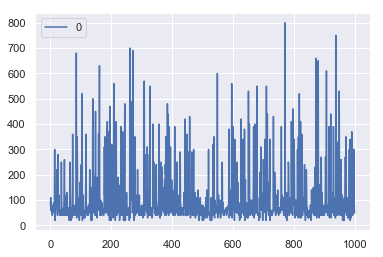

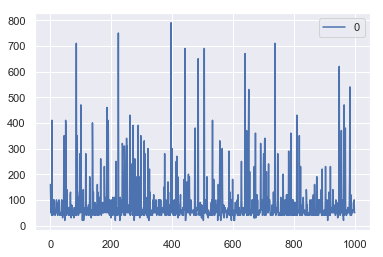

In [127]:
pd.DataFrame(y_validation_sub).plot()
pd.DataFrame(y_pred).plot()

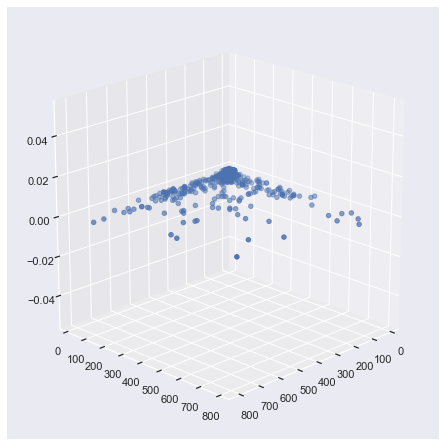

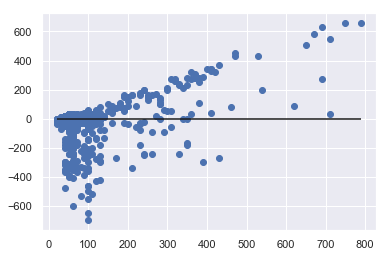

In [135]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(6, 6))
axes = Axes3D(fig, elev=20, azim=45)
axes.scatter(y_validation_sub, y_pred, cmap=plt.cm.get_cmap("viridis"))   #("Spectral"))
plt.show()


# Plot Residuals
#plt.scatter(predictions, predictions - y_train_sub)
plt.scatter(y_pred, y_pred - y_validation_sub)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max())
plt.show()

## Multiple Linear Regression model

In [136]:
from sklearn.datasets import make_regression

n_features = 3
X, y = make_regression(n_samples=3000, n_features=n_features, 
                       n_informative=n_features, random_state=42, 
                       noise=0.5, bias=100.0)
print(X.shape)

(3000, 3)


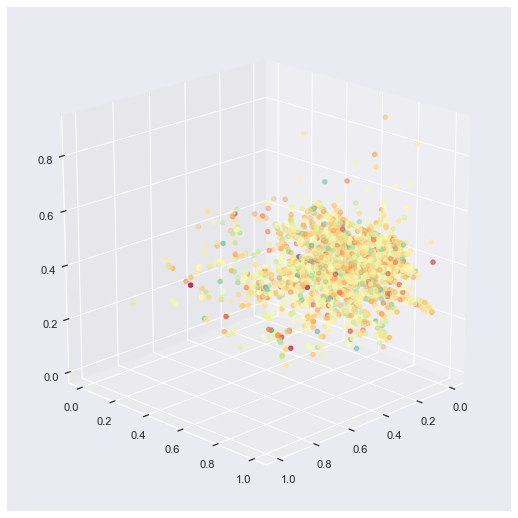

In [139]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(7, 7))
axes = Axes3D(fig, elev=20, azim=45)
axes.scatter(X_train_sub[0:3000,0], X_train_sub[0:3000,1], X_train_sub[0:3000,2], c=y, cmap=plt.cm.get_cmap("Spectral"))
plt.show()

In [140]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Fitting our model with all of our features in X
model.fit(X_train_sub, y_train_sub)

score = model.score(X_train_sub, y_train_sub)
print(f"R2 Score: {score}")

R2 Score: 0.25733997563355304


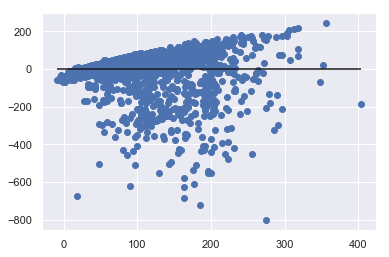

In [141]:
predictions = model.predict(X_train_sub)
# Plot Residuals
plt.scatter(predictions, predictions - y_train_sub)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.show()

## Support vector machine w/radial kernel

In [142]:
# Import packages to visualize the classifer
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import warnings

# Import packages to do the classifying
import numpy as np
from sklearn.svm import SVC

In [143]:
def versiontuple(v):
    return tuple(map(int, (v.split("."))))


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.figure(figsize=(12, 5), dpi=300)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
#        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
#                    alpha=0.8, c=cmap(idx),
#                    marker=markers[idx], label=cl)
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx))

    # highlight test samples
    if test_idx:
        # plot all samples
        if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
            X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
            warnings.warn('Please update to NumPy 1.9.0 or newer')
        else:
            X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

In [144]:
X_train_sub.shape

(3000, 34)

In [145]:
y_train_sub.shape

(3000,)

In [146]:
#X_train_sub[0:100,1:3]
y_train_sub[:100]

array([ 40.,  50., 120.,  50.,  90.,  40.,  50., 400.,  60.,  70.,  90.,
       300.,  20.,  50.,  20., 100.,  70.,  70.,  60.,  70., 200., 260.,
        80., 270.,  50., 140.,  40.,  60.,  40.,  40.,  60.,  50.,  50.,
        40.,  50., 140.,  60., 100.,  50.,  20.,  80.,  40.,  70.,  40.,
        50.,  30., 220.,  80.,  70.,  40.,  50.,  80.,  60., 310., 120.,
        60., 110.,  60.,  70.,  30.,  50.,  60.,  40., 380.,  30.,  70.,
        50.,  40.,  40.,  50.,  20.,  50.,  70.,  60.,  40.,  60., 120.,
       100.,  60.,  50.,  80.,  50.,  50.,  20.,  50., 140.,  80.,  70.,
        50.,  70.,  40.,  30.,  50.,  50.,  40., 130.,  60.,  30.,  50.,
        50.])

In [148]:
X_xor = X_train_sub[:,1:3]
y_xor = y_train_sub[:]

# Create a SVC classifier using an RBF kernel
#svm = SVC(kernel='rbf', random_state=0, gamma=.01, C=1)
# Train the classifier
#svm.fit(X_xor, y_xor)
svm.fit(X_xor, y_xor)

# Visualize the decision boundaries
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

NameError: name 'svm' is not defined

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

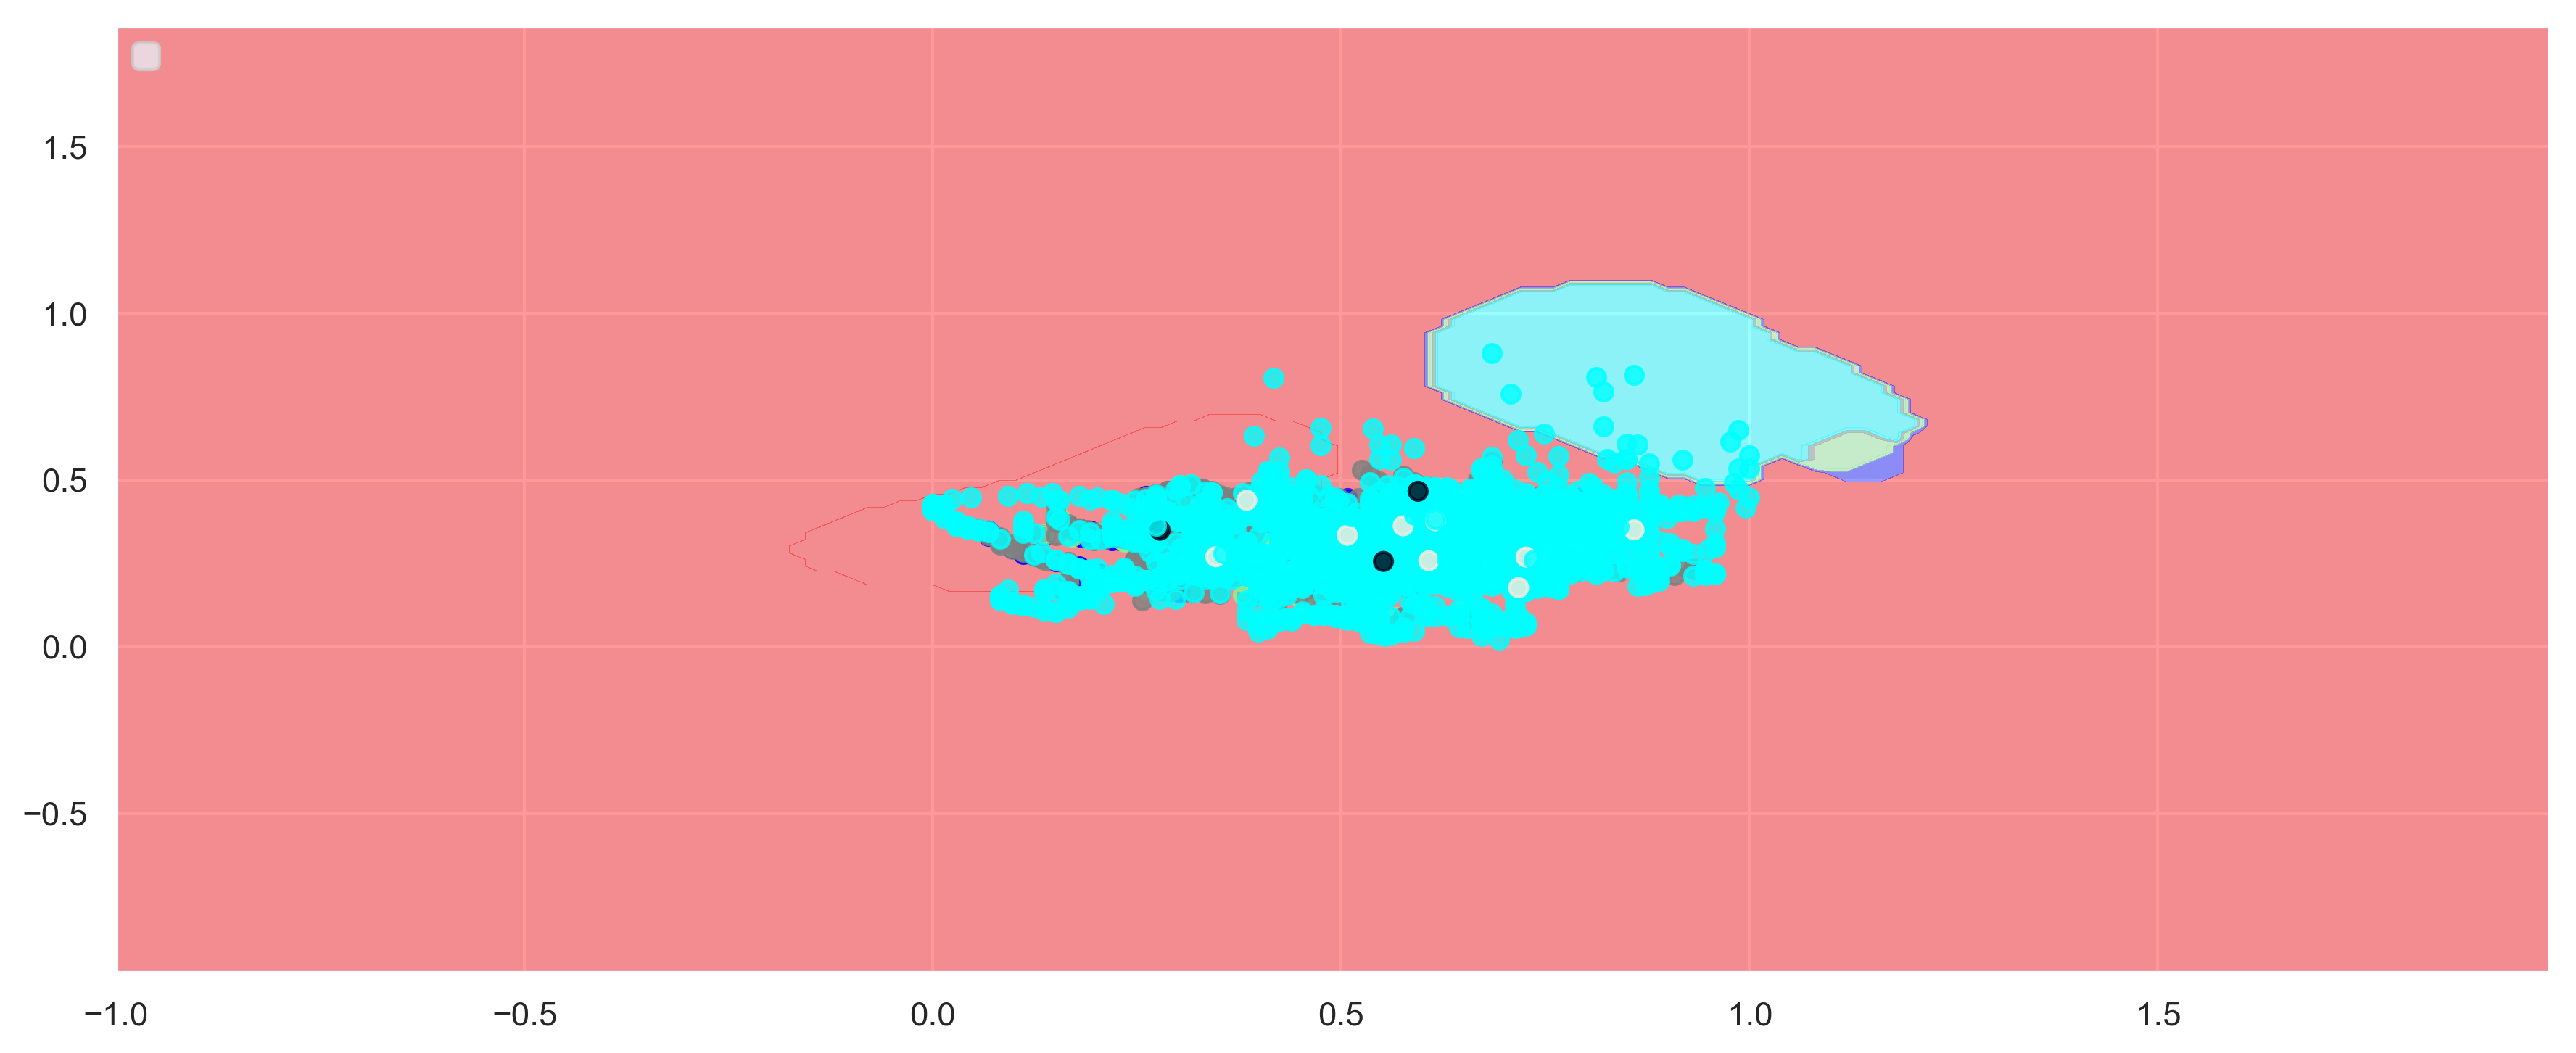

In [149]:
# Create a SVC classifier using an RBF kernel
svm = SVC(kernel='rbf', random_state=0, gamma=10, C=1)
# Train the classifier
svm.fit(X_xor, y_xor)

# Visualize the decision boundaries
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

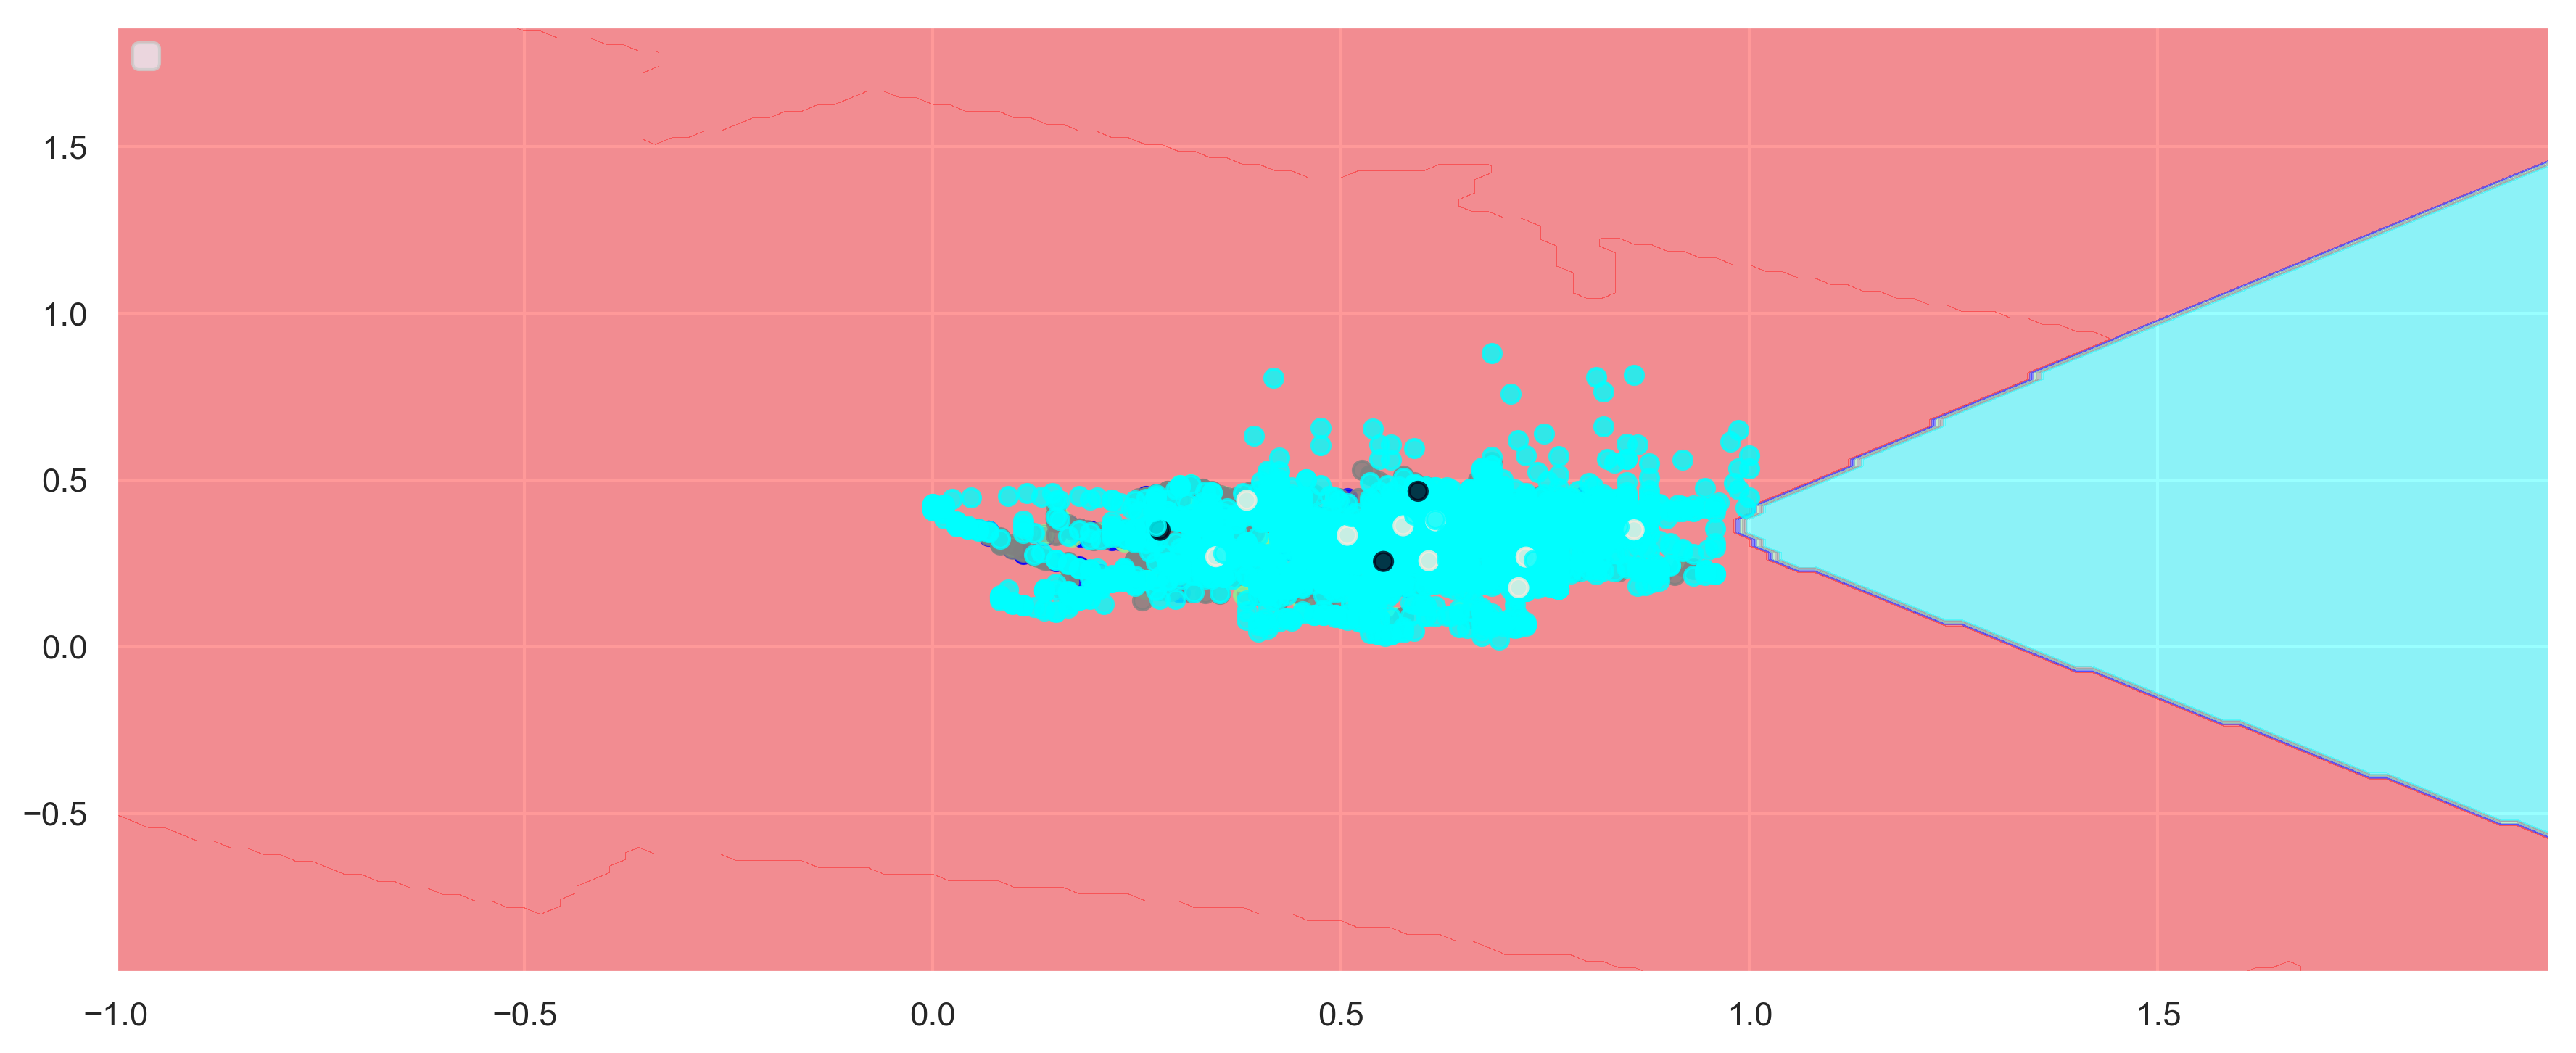

In [150]:
# Create a SVC classifier using an RBF kernel
svm = SVC(kernel='rbf', random_state=0, gamma=.01, C=100000)
# Train the classifier
svm.fit(X_xor, y_xor)

# Visualize the decision boundaries
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [151]:
# Create a SVC classifier using an RBF kernel
svm = SVC(kernel='rbf', random_state=0, gamma=.01, C=1000)
# Train the classifier
print(X_xor.shape)
print(y_xor.shape)
svm.fit(X_xor, y_xor)
X_test=X_validation_sub[:,1:3]
print(X_test.shape)
print(y_validation_sub.shape)

predictions = svm.predict(X_test)

(3000, 2)
(3000,)
(1000, 2)
(1000,)


In [152]:
# Calculate classification report
from sklearn.metrics import classification_report, confusion_matrix 
 
print(confusion_matrix(y_validation_sub,predictions))  
print(classification_report(y_validation_sub,predictions)) 

[[ 0  0 17 ...  0  0  0]
 [ 0  0 21 ...  0  0  0]
 [ 0  0 78 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


C:\Users\golivera\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\golivera\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\golivera\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

        20.0       0.00      0.00      0.00        34
        30.0       0.00      0.00      0.00        52
        40.0       0.27      0.45      0.33       175
        50.0       0.19      0.73      0.30       186
        60.0       0.00      0.00      0.00       110
        70.0       0.00      0.00      0.00        72
        80.0       0.00      0.00      0.00        53
        90.0       0.00      0.00      0.00        35
       100.0       0.00      0.00      0.00        46
       110.0       0.00      0.00      0.00        29
       120.0       0.00      0.00      0.00        26
       130.0       0.00      0.00      0.00        14
       140.0       0.00      0.00      0.00        11
       150.0       0.00      0.00      0.00         6
       160.0       0.00      0.00      0.00         4
       170.0       0.00      0.00      0.00         5
       180.0       0.00      0.00      0.00         6
       190.0       0.00    

In [153]:
print(predictions)

[50. 50. 50. 50. 40. 50. 40. 50. 40. 40. 50. 50. 50. 50. 50. 40. 50. 50.
 50. 50. 50. 40. 40. 50. 40. 50. 50. 50. 50. 50. 40. 50. 40. 50. 50. 40.
 50. 50. 50. 50. 50. 40. 50. 50. 50. 50. 50. 40. 50. 40. 40. 50. 50. 40.
 40. 50. 50. 50. 50. 50. 40. 50. 50. 50. 50. 50. 40. 50. 50. 40. 40. 40.
 50. 50. 50. 50. 50. 50. 40. 50. 40. 50. 50. 50. 50. 40. 50. 50. 40. 40.
 50. 50. 50. 50. 50. 40. 50. 40. 50. 50. 50. 50. 50. 50. 50. 40. 40. 40.
 40. 50. 50. 50. 50. 50. 50. 50. 40. 40. 50. 40. 50. 50. 50. 50. 50. 40.
 50. 50. 40. 50. 50. 50. 50. 40. 50. 50. 40. 40. 50. 50. 50. 50. 50. 50.
 40. 50. 50. 50. 50. 50. 50. 50. 40. 40. 50. 40. 50. 40. 40. 40. 40. 50.
 50. 40. 50. 40. 40. 50. 40. 50. 50. 50. 40. 50. 50. 50. 50. 50. 40. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 40. 40. 50. 50. 40. 50. 50. 50.
 50. 40. 50. 50. 50. 40. 50. 50. 50. 50. 50. 50. 50. 40. 50. 40. 50. 40.
 50. 50. 40. 40. 50. 40. 50. 50. 50. 50. 50. 40. 40. 50. 50. 50. 50. 40.
 50. 40. 50. 50. 50. 50. 50. 50. 40. 40. 50. 50. 40